# Single agent

Filtering for images containing ONLY 'cat or dog'...
Done! Found 812 images with ONLY 'cat or dog'.

Filtering validation images containing ONLY 'cat or dog'...
Done! Found 809 validation images with ONLY 'cat or dog'.
<PIL.Image.Image image mode=RGB size=426x500 at 0x2B975AFD5D0>


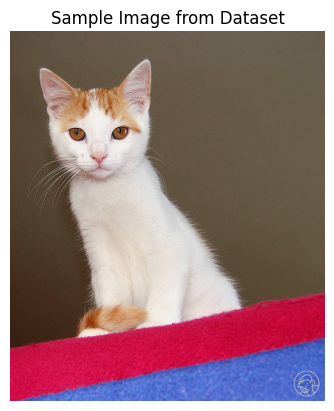


══════════════════════════════════════════════════════════════════════
Episode: 20/2000 [                    ] 1.0%
Time Elapsed: 00:00:32 | ETR: 00:53:00
Epsilon:     1.000   
──────────────────────────────────────────────────────────────────────
 Metrics (Avg over last 20):
   ┣━ Reward:      -50.21  
   ┣━ Loss:        0.0000  
   ┗━ Ep. Length:  24.5     steps

⏮Last Episode:
   ┣━ Reward:      -15.94  
   ┗━ Length:      34       steps
══════════════════════════════════════════════════════════════════════

══════════════════════════════════════════════════════════════════════
Episode: 40/2000 [                    ] 2.0%
Time Elapsed: 00:01:11 | ETR: 00:58:01
Epsilon:     0.966   
──────────────────────────────────────────────────────────────────────
 Metrics (Avg over last 20):
   ┣━ Reward:      -53.73  
   ┣━ Loss:        2.7221  
   ┗━ Ep. Length:  89.5     steps

⏮Last Episode:
   ┣━ Reward:      -39.57  
   ┗━ Length:      99       steps
═════════════════════════════════════

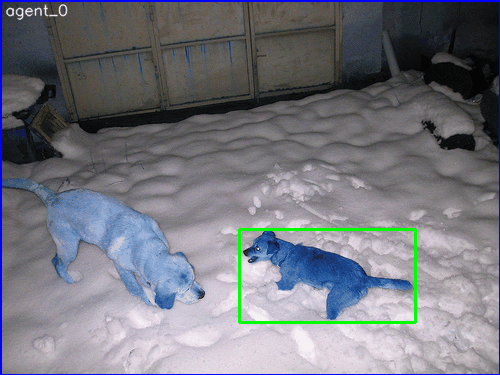

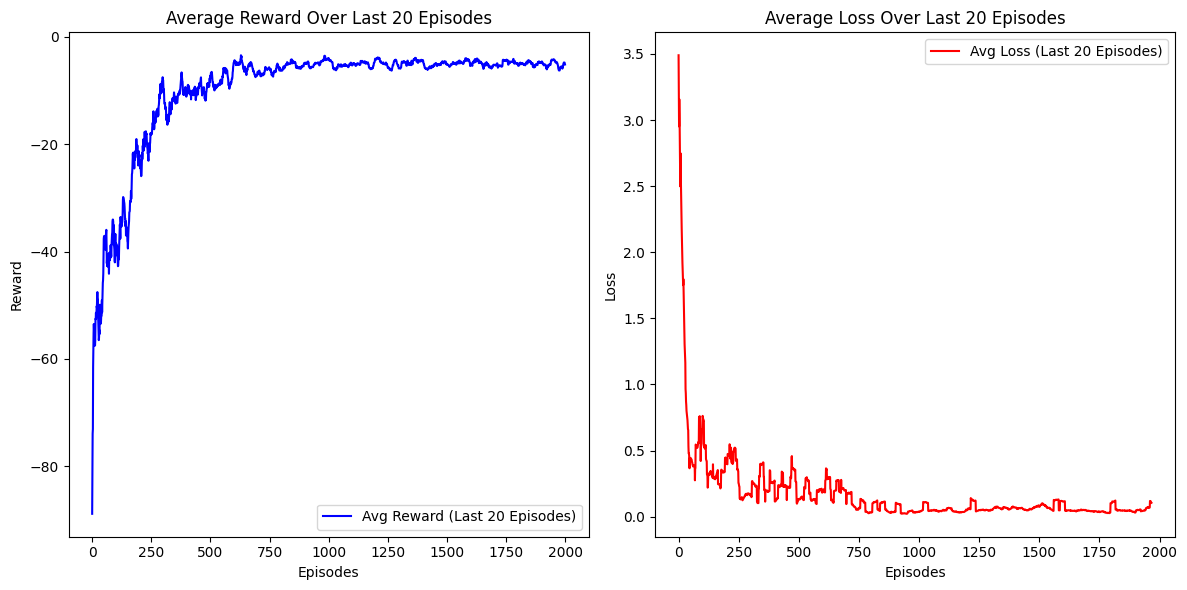

In [5]:
 
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import VOCDetection

TARGET_CLASSES = ['cat', 'dog'] # Image types that we're concidering
DATA_ROOT = './data'
# Loading the dataset
try:
    original_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='train',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"Filtering for images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

filtered_indices = []
for i in range(len(original_dataset)):
    target = original_dataset[i][1] # 
    objects = target['annotation']['object'] # EXtract bounding box

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects] # Extract object labels

    if all(label in TARGET_CLASSES for label in all_labels): 
        filtered_indices.append(i)

print(f"Done! Found {len(filtered_indices)} images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_dataset = Subset(original_dataset, filtered_indices)
try:
    val_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='val',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"\nFiltering validation images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

val_filtered_indices = []
for i in range(len(val_dataset)):
    target = val_dataset[i][1]
    objects = target['annotation']['object']

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects]

    if all(label in TARGET_CLASSES for label in all_labels): # Check that all labels are from target classes
        val_filtered_indices.append(i)

print(f"Done! Found {len(val_filtered_indices)} validation images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_val_dataset = Subset(val_dataset, val_filtered_indices)
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
# Showing a random image
if filtered_dataset:
    idx = np.random.randint(0, len(filtered_dataset))
    image, target = filtered_dataset[idx]
    print(image)
    plt.imshow(image)
    plt.title("Sample Image from Dataset")
    plt.axis('off')  
    plt.show()
import torchvision.transforms as T
from torchvision.models import vgg16
from torchvision.datasets import VOCDetection
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from pettingzoo.utils.env import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import gymnasium as gym
from gymnasium import spaces
from pettingzoo.utils.agent_selector import AgentSelector



def env_creator(env_config):
    return MultiAgentObjectDetectionEnv(**env_config)

class MultiAgentObjectDetectionEnv(AECEnv): # Our envirnment 
    metadata = {'render_modes': 'rgb_array', 'render_fps': 30, "is_parallelizable": True}

    def __init__(self, dataset, num_agents=1, alpha=0.05, max_steps=100): # aloha : how much agent agent move per action 
        # max_steps : maximum number of steps each agent can take before triggering & num_agent : unmber of agents work on  every image
        super().__init__()
        self.alpha = alpha
        self.max_steps = max_steps
        self.dataset = dataset
        # Define possible agents
        #self.possible_agents = [f"agent_{i}" for i in range(num_agents)]
        #  Initialize self.agents so PettingZoo's num_agents works
        #self.agents = []
        # Also define num_agents explicitly for clarity
        #self.num_agents = num_agents
        
        if torch.cuda.is_available():# We use GPU if available 
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")
    # We use vgg16 for data extraction so we load it and remove last layer 
        vgg_model = vgg16(pretrained=True).eval().to(self.device)
        self.feature_extractor = torch.nn.Sequential(
            *list(vgg_model.features),
            vgg_model.avgpool,
            torch.nn.Flatten(),
            vgg_model.classifier[0]
        ).to(self.device)
# resize , conver to tensors & normalize for VGG16
        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create an empty list to store agent names
        self.possible_agents = []

        # Loop over the range of num_agents (this will run num_agents times)
        for i in range(num_agents):
            # For each number in the loop, create a string "agent_i" (e.g. "agent_0", "agent_1", etc.)
            agent_name = f"agent_{i}"
            
            # Add the created agent name to the list
            self.possible_agents.append(agent_name)
        # Create an empty dictionary to store the mapping of agent names to numbers
        self.agent_name_mapping = {}

        # Loop over each agent name and its index (position) in the list of possible agents
        for i, agent_name in enumerate(self.possible_agents):
            # Add the agent name as the key and its index as the value in the dictionary
            self.agent_name_mapping[agent_name] = i
        
        observation_shape = (4186,)
        # Create an empty dictionary to store observation spaces for each agent
        self._observation_spaces = {}

        # Loop through each agent in the possible_agents list
        for agent in self.possible_agents:
            # Create an observation space for each agent using a box with a specific range
            # A Box space means the agent can have a wide range of possible values (in this case, from negative infinity to positive infinity)
            # 'shape' defines the size of the space (the number of values for each observation)
            # 'dtype' specifies the type of data we are working with (in this case, float32 numbers)
            self._observation_spaces[agent] = spaces.Box(low=-np.inf, high=np.inf, shape=observation_shape, dtype=np.float32)
        # Define the action space for each agent.
        # Each agent can choose from 9 possible actions, so we use Discrete(9) to represent this.
        self._action_spaces = {}

        # Loop through each agent and assign them an action space.
        for agent in self.possible_agents:
            self._action_spaces[agent] = spaces.Discrete(9)
                
        self.agent_colors = [(255, 0, 0), (0, 0, 255), (255, 255, 0)] # BGR for OpenCV


    def observation_space(self, agent):
        return self._observation_spaces[agent]

    def action_space(self, agent):
        return self._action_spaces[agent]

    def _parse_bbox(self, bndbox):
        return np.array([
            int(bndbox["xmin"]), int(bndbox["ymin"]),
            int(bndbox["xmax"]), int(bndbox["ymax"]),
        ])
    def _get_obs_for_agent(self, agent):
        x1, y1, x2, y2 = self.boxes[agent] # Extract edges of box
        region = self.img[y1:y2, x1:x2] # construct the box
        
        if region.size == 0:
            region = np.zeros((1, 1, 3), dtype=np.uint8)

        region_img = Image.fromarray(region).convert("RGB")
        region_tensor = self.transform(region_img).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            features = self.feature_extractor(region_tensor).cpu().numpy().flatten()
        
        history_flat = self.histories[agent].flatten()
        obs = np.concatenate([features, history_flat]).astype(np.float32) # Build history using fatures extracted from VGG16 and ten past actions
        return obs

    def observe(self, agent):
        return self._get_obs_for_agent(agent)
        
    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
      
        # Initialize the dictionaries for rewards, cumulative rewards, terminations, truncations, and info for each agent.

        # This creates a dictionary where each agent starts with a reward of 0.
        self.rewards = {}
        for agent in self.agents:
            self.rewards[agent] = 0

        # This creates a dictionary where each agent starts with a cumulative reward of 0 (tracking the total reward).
        self._cumulative_rewards = {}
        for agent in self.agents:
            self._cumulative_rewards[agent] = 0

        # This creates a dictionary where each agent starts with 'False' for termination (i.e., the agent is not terminated yet).
        self.terminations = {}
        for agent in self.agents:
            self.terminations[agent] = False

        # This creates a dictionary where each agent starts with 'False' for truncation (i.e., the agent is not truncated yet).
        self.truncations = {}
        for agent in self.agents:
            self.truncations[agent] = False

        # This creates a dictionary for additional information about each agent, starting as an empty dictionary.
        self.infos = {}
        for agent in self.agents:
            self.infos[agent] = {}

    
        self.current_step = 0
        self.index = random.randint(0, len(self.dataset) - 1)
        img, annotation = self.dataset[self.index]
        self.img = np.array(img)
        objects = annotation["annotation"]["object"]
        obj = objects[0] if isinstance(objects, list) else objects
        self.gt_box = self._parse_bbox(obj["bndbox"])
        
        height, width = self.img.shape[:2]
        agent_width = width // len(self.agents)
        agent_height = height // len(self.agents)
        self.boxes = {}
        for i, agent in enumerate(self.agents):
            x1 = i * agent_width
            x2 = (i + 1) * agent_width
            if i == len(self.agents) - 1:
                x2 = width
                
            self.boxes[agent] = np.array([0, 0, width, height], dtype=np.int32)
    
        self.histories = {agent: np.zeros((10, 9), dtype=np.float32) for agent in self.agents}
        self.ious = {agent: self._compute_iou(self.boxes[agent], self.gt_box) for agent in self.agents}
    
        self._agent_selector = AgentSelector(self.agents)
        self.agent_selection = self._agent_selector.next()
        
        observations = {agent: self.observe(agent) for agent in self.agents}
        return observations, self.infos


    def step(self, action):
        agent = self.agent_selection
    
        if self.terminations[agent] or self.truncations[agent]:
            self._was_dead_step(action)
            return
    
        self.rewards[agent] = 0
        
        prev_iou = self.ious[agent]
        self._apply_action_for_agent(agent, action)
        new_iou = self._compute_iou(self.boxes[agent], self.gt_box)
        self.ious[agent] = new_iou
        
        if action == 8:  # Trigger action
            if new_iou >= 0.80:
                # If IoU is greater than or equal to 0.80, assign a positive reward and terminate the agent
                self.rewards[agent] = 5.0
                self.terminations[agent] = True  # End the agent's episode
            else:
                # If IoU is less than 0.80, assign a negative reward and continue stepping (do not terminate)
                self.rewards[agent] = -5.0
                self.terminations[agent] = False  # Ensure the agent's episode does not terminate
        else:
            # For all other actions, update the reward based on the IoU change
            self.rewards[agent] = (new_iou - prev_iou) * 10.0 - 0.05  # Small penalty for each step

    
        self._cumulative_rewards[agent] += self.rewards[agent]
    
        self.histories[agent] = np.roll(self.histories[agent], shift=-1, axis=0)
        self.histories[agent][-1] = np.eye(9)[action]
    
        if self._agent_selector.is_last():
            self.current_step += 1
            if self.current_step >= self.max_steps:
                for ag in self.agents:
                    self.truncations[ag] = True
        
        self.agent_selection = self._agent_selector.next()

    def _was_dead_step(self, action):
        """
        Custom override: when an agent is dead, remove it from the active list
        but KEEP its entries in the per-agent dicts so last() never KeyErrors.
        Also handle the final-agent case gracefully.
        """
        if action is not None:
            raise ValueError("when an agent is dead, the only valid action is None")

        agent = self.agent_selection
        assert self.terminations.get(agent, False) or self.truncations.get(agent, False), (
            f"Agent {agent} is not marked dead but _was_dead_step was called"
        )

        # Remove from active roster
        self.agents.remove(agent)

        # If no agents left, clear selection and exit
        if not self.agents:
            self.agent_selection = None
            # clear any residual rewards but keep dict keys intact
            self._clear_rewards()
            return

        # Advance to the next agent:
        # 1) Prefer any other already‐dead agent (so last() can be called on them)
        dead_list = [ag for ag in self.agents if self.terminations[ag] or self.truncations[ag]]
        if dead_list:
            self.agent_selection = dead_list[0]
        else:
            # 2) Otherwise restore skip pointer if present, or just take the first live one
            self.agent_selection = getattr(self, "_skip_agent_selection", None) or self.agents[0]
            self._skip_agent_selection = None

        # Clear step‐rewards but keep all dict entries
        self._clear_rewards()


    def _apply_action_for_agent(self, agent, action):
        x1, y1, x2, y2 = self.boxes[agent]
        w, h = x2 - x1, y2 - y1
        dx, dy = self.alpha * w, self.alpha * h
        
        action_map = {
            0: (-dx, 0, -dx, 0),    # Move left
            1: (dx, 0, dx, 0),     # Move right
            2: (0, -dy, 0, -dy),   # Move up
            3: (0, dy, 0, dy),     # Move down
            4: (-dx, -dy, dx, dy), # Bigger
            5: (dx, dy, -dx, -dy),  # Smaller
            6: (-dx, 0, dx, 0),    # Fatter
            7: (0, -dy, 0, dy),    # Taller
        }
        
        if action in action_map:
            dx1, dy1, dx2, dy2 = action_map[action]
            x1, y1, x2, y2 = x1 + dx1, y1 + dy1, x2 + dx2, y2 + dy2

        h_img, w_img = self.img.shape[:2] # Keep bounding box in the image
        x1, x2 = np.clip([x1, x2], 0, w_img)
        y1, y2 = np.clip([y1, y2], 0, h_img)
        # Keep x1 and y1 always lowr than x2 and y2 
        if x2 <= x1: x2 = x1 + 1
        if y2 <= y1: y2 = y1 + 1

        self.boxes[agent] = np.array([int(x1), int(y1), int(x2), int(y2)])

    def _compute_iou(self, boxA, boxB):# compote IOU
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        
        iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
        return iou

    def render(self):
        img_to_show = self.img.copy()
        
        gx1, gy1, gx2, gy2 = self.gt_box
        cv2.rectangle(img_to_show, (int(gx1), int(gy1)), (int(gx2), int(gy2)), (0, 255, 0), 2)
        
        for i, agent in enumerate(self.agents):
            x1, y1, x2, y2 = self.boxes[agent]
            color = self.agent_colors[i % len(self.agent_colors)]
            cv2.rectangle(img_to_show, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_color = (255, 255, 255) # White color for good contrast
            thickness = 1
            text_position = (int(x1) + 5, int(y1) + 15)
            cv2.putText(img_to_show, agent, text_position, font, font_scale, font_color, thickness, cv2.LINE_AA)
                
        img_rgb = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
        return img_rgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from typing import Dict, List, Tuple, Optional
import copy
import time
import os


def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Make PyTorch deterministic 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for additional determinism
    os.environ['PYTHONHASHSEED'] = str(seed)

class QNetwork(nn.Module):
    """Individual Q-network for each agent"""
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class QMixNet(nn.Module):
    """ Combine indivisual Q valiues into a joint action under Qmix condition"""

    def __init__(self, n_agents: int, state_dim: int, hidden_dim: int = 32):
        super(QMixNet, self).__init__()
        self.n_agents = n_agents
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        
        # Hypernetworks for weights and biases
        self.hyper_w1 = nn.Linear(state_dim, hidden_dim * n_agents)
        self.hyper_w2 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b1 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, agent_qs, states):
        """
        agent_qs: [batch_size, n_agents]
        states: [batch_size, state_dim]
        """
        batch_size = agent_qs.size(0)
        
        # Generate weights and biases
        w1 = torch.abs(self.hyper_w1(states))  # Ensure positive weights
        w1 = w1.view(batch_size, self.n_agents, self.hidden_dim)
        
        b1 = self.hyper_b1(states)
        b1 = b1.view(batch_size, 1, self.hidden_dim)
        
        # First layer
        agent_qs = agent_qs.view(batch_size, 1, self.n_agents)
        hidden = F.elu(torch.bmm(agent_qs, w1) + b1)
        
        # Second layer
        w2 = torch.abs(self.hyper_w2(states))
        w2 = w2.view(batch_size, self.hidden_dim, 1)
        
        b2 = self.hyper_b2(states)
        b2 = b2.view(batch_size, 1, 1)
        
        q_tot = torch.bmm(hidden, w2) + b2
        q_tot = q_tot.view(batch_size, 1)
        
        return q_tot

class ReplayBuffer:
    """building replay buffer to store past experience"""
    def __init__(self, capacity: int, n_agents: int, obs_dim: int, state_dim: int):
        self.capacity = capacity
        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.state_dim = state_dim
        
        self.observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.actions = np.zeros((capacity, n_agents), dtype=np.int64)
        self.rewards = np.zeros((capacity, n_agents), dtype=np.float32)
        self.next_observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.dones = np.zeros((capacity, n_agents), dtype=np.bool_)
        
        self.ptr = 0
        self.size = 0
        
    def store(self, obs, actions, rewards, next_obs, states, next_states, dones):
        self.observations[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.next_observations[self.ptr] = next_obs
        self.states[self.ptr] = states
        self.next_states[self.ptr] = next_states
        self.dones[self.ptr] = dones
        
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
        
    def sample(self, batch_size: int, device: torch.device):
        """Sample batch and move to specified device"""
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        return {
            'observations': torch.FloatTensor(self.observations[idxs]).to(device),
            'actions': torch.LongTensor(self.actions[idxs]).to(device),
            'rewards': torch.FloatTensor(self.rewards[idxs]).to(device),
            'next_observations': torch.FloatTensor(self.next_observations[idxs]).to(device),
            'states': torch.FloatTensor(self.states[idxs]).to(device),
            'next_states': torch.FloatTensor(self.next_states[idxs]).to(device),
            'dones': torch.BoolTensor(self.dones[idxs]).to(device)
        }

class QMIX:
    """QMIX algorithm implementation"""
    def __init__(
        self,
        n_agents: int,
        obs_dim: int,
        action_dim: int,
        state_dim: int,
        lr: float = 1e-3,
        gamma: float = 0.99,
        epsilon: float = 1.0,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.01,
        tau: float = 0.005,
        hidden_dim: int = 128,
        buffer_size: int = 10000,
        batch_size: int = 32,
        device: str = 'cpu',
        seed: Optional[int] = None):
    
        if seed is not None:
            set_random_seed(seed)

        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.batch_size = batch_size
        self.device = torch.device(device)
        
        # Nets per agents
        self.q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        
        self.target_q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        # Mixing nets 
        self.qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        self.target_qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        
        # Copy weights to target networks
        self.hard_update(self.target_q_networks, self.q_networks)
        self.hard_update(self.target_qmix_net, self.qmix_net)
        
        # Optimizer(adam)
        self.optimizer = torch.optim.Adam(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            lr=lr
        )
        
        # Replay buffer
        self.buffer = ReplayBuffer(buffer_size, n_agents, obs_dim, state_dim)
        
    def hard_update(self, target, source):
        """Hard update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
    
    def soft_update(self, target, source, tau):
        """Soft update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
    def get_actions(self, observations: Dict[str, np.ndarray], epsilon: Optional[float] = None) -> Dict[str, int]:
        """Get actions for all agents using epsilon-greedy policy"""
        if epsilon is None:
            epsilon = self.epsilon
            
        actions = {}
        agent_names = list(observations.keys())
        
        if not agent_names:
            return actions
        
        # Convert observations to tensor and move to device
        obs_array = np.array([observations[agent] for agent in agent_names])
        obs_tensor = torch.FloatTensor(obs_array).to(self.device)
        
        with torch.no_grad():
            q_values = []
            for i, agent in enumerate(agent_names):
                q_vals = self.q_networks[i](obs_tensor[i].unsqueeze(0))
                q_values.append(q_vals)
        
        for i, agent in enumerate(agent_names):
            if random.random() < epsilon:
                actions[agent] = random.randint(0, self.action_dim - 1)
            else:
                actions[agent] = q_values[i].argmax().item()
                
        return actions
    
    def get_state(self, env) -> np.ndarray:
        """Extract global state from environment"""
        # Combine all agent observations and environment info
        state_components = []
        
        # Add current step normalized
        state_components.append(env.current_step / env.max_steps)
        
        # Add all agent box positions normalized
        for agent in env.agents:
            box = env.boxes[agent]
            h, w = env.img.shape[:2]
            normalized_box = [box[0]/w, box[1]/h, box[2]/w, box[3]/h]
            state_components.extend(normalized_box)
        
        # Add ground truth box normalized
        gt_box = env.gt_box
        normalized_gt = [gt_box[0]/w, gt_box[1]/h, gt_box[2]/w, gt_box[3]/h]
        state_components.extend(normalized_gt)
        
        # Add IoU values
        for agent in env.agents:
            state_components.append(env.ious[agent])
        
        # Pad or truncate to fixed size
        target_size = self.state_dim
        if len(state_components) < target_size:
            state_components.extend([0.0] * (target_size - len(state_components)))
        else:
            state_components = state_components[:target_size]
            
        return np.array(state_components, dtype=np.float32)
    
    def store_transition(self, obs, actions, rewards, next_obs, states, next_states, dones):
        """Store per agent data in replay buffer"""
        agent_names = list(obs.keys())
        
        # Convert to arrays, handling missing agents
        obs_array = np.array([obs[agent] for agent in agent_names])
        actions_array = np.array([actions[agent] for agent in agent_names])
        rewards_array = np.array([rewards.get(agent, 0.0) for agent in agent_names])
        
        # For next_obs, use previous obs if agent is missing (terminated)
        next_obs_array = np.array([
            next_obs[agent] if agent in next_obs else obs[agent] 
            for agent in agent_names
        ])
        
        dones_array = np.array([dones.get(agent, False) for agent in agent_names])
        
        self.buffer.store(obs_array, actions_array, rewards_array, next_obs_array, 
                         states, next_states, dones_array)
    
    def update(self):
        """Update networks using QMIX algorithm"""
        if self.buffer.size < self.batch_size:
            return None
            
        # Sample batch and ensure all tensors are on the correct device
        batch = self.buffer.sample(self.batch_size, self.device)
        
        # Current Q-values
        current_q_values = []
        for i in range(self.n_agents):
            q_vals = self.q_networks[i](batch['observations'][:, i])
            current_q_values.append(q_vals.gather(1, batch['actions'][:, i].unsqueeze(1)).squeeze(1))
        
        current_q_values = torch.stack(current_q_values, dim=1)  # [batch_size, n_agents]
        
        # Target Q-values
        with torch.no_grad():
            target_q_values = []
            for i in range(self.n_agents):
                target_q_vals = self.target_q_networks[i](batch['next_observations'][:, i])
                target_q_values.append(target_q_vals.max(1)[0])
            
            target_q_values = torch.stack(target_q_values, dim=1)  # [batch_size, n_agents]
            
            # Apply done mask
            target_q_values = target_q_values * (~batch['dones']).float()
        
        # Mix Q-values
        current_q_tot = self.qmix_net(current_q_values, batch['states'])
        target_q_tot = self.target_qmix_net(target_q_values, batch['next_states'])
        
        # Compute target
        targets = batch['rewards'].sum(dim=1, keepdim=True) + self.gamma * target_q_tot
        
        # Compute loss
        loss = F.mse_loss(current_q_tot, targets)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            max_norm=1.0
        )
        self.optimizer.step()
        
        # Update target networks
        self.soft_update(self.target_q_networks, self.q_networks, self.tau)
        self.soft_update(self.target_qmix_net, self.qmix_net, self.tau)
        
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        
        return loss.item()

def train_qmix(env, episodes: int = 2000, max_steps: int = 100,  seed: int = 42):
    """Training loop for QMIX on the multi-agent object detection environment"""

    # Set random seed at the beginning of training
    set_random_seed(seed)
    
    # Initialize QMIX
    n_agents = len(env.possible_agents)
    obs_dim = 4186  # From your environment
    action_dim = 9  # From your environment
    state_dim = 50  # Adjust based on your state representation
    # Define our QMix
    qmix = QMIX(
        n_agents=n_agents,
        obs_dim=obs_dim,
        action_dim=action_dim,
        state_dim=state_dim,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        seed=seed
    )
    
    episode_rewards = []
    episode_lengths = []
    losses = []
    
    start_time = time.time()
    for episode in range(episodes):
        # Reset environment
        observations, _ = env.reset()
        state = qmix.get_state(env)
        
        episode_reward = 0
        step = 0
        
        while env.agents and step < max_steps:
            # Select epsilon greedy action for active agents only   
            active_observations = {agent: observations[agent] for agent in env.agents if agent in observations}
            actions = qmix.get_actions(active_observations)
            
            # Store current state
            prev_observations = observations.copy()
            prev_state = state.copy()
            
            # Execute action for current agent
            current_agent = env.agent_selection
            if current_agent:
                # Check if current agent is dead
                is_dead = (env.terminations.get(current_agent, False) or 
                          env.truncations.get(current_agent, False))
                
                if is_dead:
                    env.step(None)  # Dead agents must receive None
                elif current_agent in actions:
                    env.step(actions[current_agent])
                else:
                    env.step(None)  # Back to None if no action available
            else:
                break  # No current agent selected
            
            # Get new observations and rewards
            next_observations = {}
            for agent in env.possible_agents:  # Check all possible agents
                if agent in env.agents:  # Only get obs for active agents
                    try:
                        next_observations[agent] = env.observe(agent)
                    except:
                        # If observation fails, use previous observation
                        if agent in prev_observations:
                            next_observations[agent] = prev_observations[agent]
                        else:
                            continue
                elif agent in prev_observations:
                    # For terminated agents, use their last observation
                    next_observations[agent] = prev_observations[agent]
                    
            episode_lengths.append(step)
            rewards = env.rewards.copy()
            dones = {agent: env.terminations.get(agent, False) or env.truncations.get(agent, False) 
                    for agent in env.possible_agents}
            
            try:
                next_state = qmix.get_state(env)
            except:
                next_state = prev_state  # Fallback if state extraction fails
            
            # Store transition only if we have complete information
            if (len(prev_observations) == n_agents and 
                len(actions) > 0 and 
                len(rewards) > 0):
                
                # Ensure we have actions and rewards for all agents
                full_actions = {}
                full_rewards = {}
                
                for agent in env.possible_agents:
                    full_actions[agent] = actions.get(agent, 0)  # Default action
                    full_rewards[agent] = rewards.get(agent, 0.0)  # Default reward
                
                qmix.store_transition(
                    prev_observations, full_actions, full_rewards, next_observations,
                    prev_state, next_state, dones
                )
            
            # Update observations and state
            observations = next_observations
            state = next_state
            
            # Calculate episode reward
            episode_reward += sum(rewards.values())
            step += 1
            
            # Check if episode is done
            if all(dones[agent] for agent in env.possible_agents) or not env.agents:
                break
        
        episode_rewards.append(episode_reward)
        
        # Update networks
        if episode > 32:  # Start training after some episodes(prevent noisy experience)
            loss = qmix.update()
            if loss is not None:
                losses.append(loss)
        
        # Print progress
        if (episode + 1) % 20 == 0:
            #  Calculate Time Metrics 
            elapsed_time = time.time() - start_time
            episodes_so_far = episode + 1
            avg_time_per_ep = elapsed_time / episodes_so_far
            remaining_eps = episodes - episodes_so_far
            etr = remaining_eps * avg_time_per_ep
            
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            etr_str = time.strftime("%H:%M:%S", time.gmtime(etr))
            
            # Calculate Metric Averages 
            avg_reward = np.mean(episode_rewards[-20:])
            avg_loss = np.mean(losses[-20:]) if losses else 0.0
            avg_ep_length = np.mean(episode_lengths[-20:])
            
            #  Get Last Episode's Stats 
            last_reward = episode_rewards[-1]
            last_ep_length = episode_lengths[-1]

            print("\n" + "═" * 70)
            progress_bar = f"[{'█' * int(20 * episodes_so_far / episodes):<20}]"
            print(f"Episode: {episodes_so_far}/{episodes} {progress_bar} {episodes_so_far / episodes:.1%}")
            print(f"Time Elapsed: {elapsed_str} | ETR: {etr_str}")
            print(f"Epsilon:     {qmix.epsilon:<8.3f}")
            print("─" * 70)
            
            print(f" Metrics (Avg over last 20):")
            print(f"   ┣━ Reward:      {avg_reward:<8.2f}")
            print(f"   ┣━ Loss:        {avg_loss:<8.4f}")
            print(f"   ┗━ Ep. Length:  {avg_ep_length:<8.1f} steps")
            print()
            
            print(f"⏮Last Episode:")
            print(f"   ┣━ Reward:      {last_reward:<8.2f}")
            print(f"   ┗━ Length:      {last_ep_length:<8} steps")  
            print("═" * 70)
    
    return qmix, episode_rewards, losses
env = MultiAgentObjectDetectionEnv(filtered_dataset, num_agents=1)

trained_qmix, rewards, losses = train_qmix(env, episodes=2000)
import imageio
from PIL import Image
from IPython.display import display
from IPython.display import Image as IImage
import time

print("\nTesting trained model and capturing frames...")
images = []
obs, _ = env.reset()

# Render the initial state
images.append(env.render())

agent_name_list = list(env.agents)
num_agents = len(agent_name_list)
initial_ious = list(env.ious)
iou_history = [[iou] for iou in initial_ious]
agent_finish_times = [None] * num_agents
start_time = time.time()
# Run a simulation for 30 steps
for step in range(30):
    if not env.agents:
        print("All agents are done. Resetting.")
        obs, _ = env.reset()
        images.append(env.render())
        
        agent_name_list = list(env.agents)
        num_agents = len(agent_name_list)
        initial_ious = list(env.ious)
        iou_history = [[iou] for iou in initial_ious]
        agent_finish_times = [None] * num_agents
        start_time = time.time()
        continue
        
    # Get actions for active agents only (using original logic)
    active_obs = {agent: obs[agent] for agent in env.agents if agent in obs}
    actions = trained_qmix.get_actions(active_obs, epsilon=0.0)  # No exploration becuase spsilon is equal to 0
    
    # Step with current agent (using original logic)
    current_agent = env.agent_selection
    if current_agent:
        # Check if current agent is dead
        is_dead = (env.terminations.get(current_agent, False) or 
                   env.truncations.get(current_agent, False))
        
        if is_dead:
            env.step(None)  # Dead agents must receive None
        elif current_agent in actions:# If agent is alive should take an action
            env.step(actions[current_agent])
        else:
            env.step(None)  # Fallback
    else:
        break
        
    # Update observations (using original logic)
    obs = {}
    for agent in env.agents:
        try:
            obs[agent] = env.observe(agent)
        except:
            continue
    
    # Track agent finish times
    current_time = time.time()
    for i, agent_name in enumerate(agent_name_list):
        if agent_finish_times[i] is None:
            is_terminated = env.terminations.get(agent_name, False)
            is_truncated = env.truncations.get(agent_name, False)
            if is_terminated or is_truncated:
                agent_finish_times[i] = current_time
    
    # Return each agent's fround truth box and agent's bounding box
    frame = env.render()
    images.append(frame)
    
    # Track IoU history
    current_ious = env.ious
    for i in range(num_agents):
        iou_history[i].append(current_ious[f'agent_{i}'])
# Ensure that all agents in agent_finished_time lebeled to simulation's end time
end_time = time.time()
for i in range(num_agents):
    if agent_finish_times[i] is None:
        agent_finish_times[i] = end_time

print("Finished simulation.")
env.close()  # It's good practice to close the environment after rendering

# Create GIF animation (list of all rendered image during simulation)
animation_path = "trained_agent_animation.gif"
imageio.mimsave(animation_path, images, duration=100, loop=0)
print("Animation saved successfully!")

# Performance summary
print("\n\n" + "═"*55)
print(" " * 15 + " Agent Performance Summary ")
print("═"*55)
# Succes thrshhold to interpret IOU into reward
SUCCESS_THRESHOLD = 0.8
# loop over each agent to calculate reward 
for i in range(num_agents):
    agent_iou_hist = [iou for iou in iou_history[i] if isinstance(iou, (float, int))]
    
    if not agent_iou_hist:
        print(f"\n╭─── Agent {i} ───╮")
        print(f"│ No data recorded. │")
        print(f"╰─────────────╯")
        continue
    
    initial_iou = agent_iou_hist[0]
    final_iou = agent_iou_hist[-1]
    max_iou_achieved = max(agent_iou_hist)
    agent_duration = agent_finish_times[i] - start_time
    # Calculate how many steps took te reach peak IOU
    steps_to_peak = 'N/A'
    if max_iou_achieved > initial_iou:
        try:
            steps_to_peak = agent_iou_hist.index(max_iou_achieved)
        except ValueError:
            steps_to_peak = 'Error'
    # assign succes or failure to agents
    status = "✅ Success" if final_iou >= SUCCESS_THRESHOLD else "❌ Failure"
    #Summerize performance
    print(f"\n╭─── Agent {i} ─────────────")
    print(f"│")
    print(f"│ 🔼 Status:             {status}")
    print(f"│ 🎯 Final IoU:          {final_iou:.4f}")
    print(f"│ 🏆 Peak IoU:           {max_iou_achieved:.4f}")
    print(f"│ ⏱️ Steps to Peak:      {steps_to_peak}")
    print(f"│ 📈 IoU Improvement:    {final_iou - initial_iou:+.4f}")
    print(f"│ ⌛ Agent Time:         {agent_duration:.2f}s")
    print(f"│")
    print(f"╰─────────────────────────")

display(IImage(filename=animation_path))

# Plotting function for rewards and losses over the last 20 episodes
def plot_rewards_and_losses(episode_rewards, losses, window=20):
    reward_avg = [np.mean(episode_rewards[max(0, i - window):i+1]) for i in range(len(episode_rewards))]
    loss_avg = [np.mean(losses[max(0, i - window):i+1]) for i in range(len(losses))]
    
    plt.figure(figsize=(12, 6))
    
    # Plot average rewards
    plt.subplot(1, 2, 1)
    plt.plot(reward_avg, label="Avg Reward (Last 20 Episodes)", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Average Reward Over Last 20 Episodes")
    plt.legend()

    # Plot average losses
    plt.subplot(1, 2, 2)
    plt.plot(loss_avg, label="Avg Loss (Last 20 Episodes)", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Average Loss Over Last 20 Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function to plot the results after training
plot_rewards_and_losses(rewards, losses)

# Multi agent reward 1

Filtering for images containing ONLY 'cat or dog'...
Done! Found 812 images with ONLY 'cat or dog'.

Filtering validation images containing ONLY 'cat or dog'...
Done! Found 809 validation images with ONLY 'cat or dog'.
<PIL.Image.Image image mode=RGB size=500x375 at 0x2B94FE3BB50>


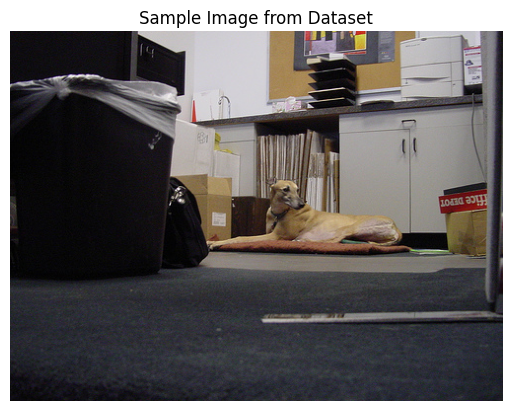


══════════════════════════════════════════════════════════════════════
Episode: 20/2000 [                    ] 1.0%
Time Elapsed: 00:00:33 | ETR: 00:55:38
Epsilon:     1.000   
──────────────────────────────────────────────────────────────────────
📊 Metrics (Avg over last 20):
   ┣━ Reward:      -39.97  
   ┣━ Loss:        0.0000  
   ┗━ Ep. Length:  19.5     steps

⏮️ Last Episode:
   ┣━ Reward:      -49.85  
   ┗━ Length:      29       steps
══════════════════════════════════════════════════════════════════════

══════════════════════════════════════════════════════════════════════
Episode: 40/2000 [                    ] 2.0%
Time Elapsed: 00:01:06 | ETR: 00:54:33
Epsilon:     0.966   
──────────────────────────────────────────────────────────────────────
📊 Metrics (Avg over last 20):
   ┣━ Reward:      -29.83  
   ┣━ Loss:        33.6996 
   ┗━ Ep. Length:  13.5     steps

⏮️ Last Episode:
   ┣━ Reward:      24.11   
   ┗━ Length:      11       steps
═══════════════════════════════

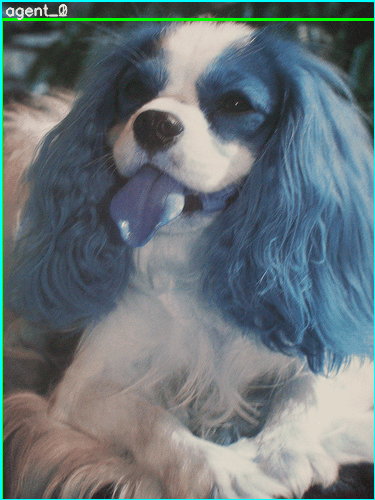

In [7]:
 
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import VOCDetection

TARGET_CLASSES = ['cat', 'dog']
DATA_ROOT = './data'

try:
    original_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='train',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"Filtering for images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

filtered_indices = []
for i in range(len(original_dataset)):
    target = original_dataset[i][1]
    objects = target['annotation']['object']

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects]

    if all(label in TARGET_CLASSES for label in all_labels):
        filtered_indices.append(i)

print(f"Done! Found {len(filtered_indices)} images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_dataset = Subset(original_dataset, filtered_indices)
try:
    val_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='val',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"\nFiltering validation images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

val_filtered_indices = []
for i in range(len(val_dataset)):
    target = val_dataset[i][1]
    objects = target['annotation']['object']

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects]

    if all(label in TARGET_CLASSES for label in all_labels):
        val_filtered_indices.append(i)

print(f"Done! Found {len(val_filtered_indices)} validation images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_val_dataset = Subset(val_dataset, val_filtered_indices)
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

if filtered_dataset:
    idx = np.random.randint(0, len(filtered_dataset))
    image, target = filtered_dataset[idx]
    print(image)
    plt.imshow(image)
    plt.title("Sample Image from Dataset")
    plt.axis('off')  
    plt.show()
import torchvision.transforms as T
from torchvision.models import vgg16
from torchvision.datasets import VOCDetection
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from pettingzoo.utils.env import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import gymnasium as gym
from gymnasium import spaces
from pettingzoo.utils.agent_selector import AgentSelector



def env_creator(env_config):
    return MultiAgentObjectDetectionEnv(**env_config)

class MultiAgentObjectDetectionEnv(AECEnv):
    metadata = {'render_modes': 'rgb_array', 'render_fps': 30, "is_parallelizable": True}

    def __init__(self, dataset, num_agents=3, alpha=0.05, max_steps=100):
        super().__init__()
        self.alpha = alpha
        self.max_steps = max_steps
        self.dataset = dataset
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        vgg_model = vgg16(pretrained=True).eval().to(self.device)
        self.feature_extractor = torch.nn.Sequential(
            *list(vgg_model.features),
            vgg_model.avgpool,
            torch.nn.Flatten(),
            vgg_model.classifier[0]
        ).to(self.device)

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create an empty list to store agent names
        self.possible_agents = []

        # Loop over the range of num_agents (this will run num_agents times)
        for i in range(num_agents):
            # For each number in the loop, create a string "agent_i" (e.g. "agent_0", "agent_1", etc.)
            agent_name = f"agent_{i}"
            
            # Add the created agent name to the list
            self.possible_agents.append(agent_name)
        # Create an empty dictionary to store the mapping of agent names to numbers
        self.agent_name_mapping = {}

        # Loop over each agent name and its index (position) in the list of possible agents
        for i, agent_name in enumerate(self.possible_agents):
            # Add the agent name as the key and its index as the value in the dictionary
            self.agent_name_mapping[agent_name] = i
        
        observation_shape = (4186,)
        # Create an empty dictionary to store observation spaces for each agent
        self._observation_spaces = {}

        # Loop through each agent in the possible_agents list
        for agent in self.possible_agents:
            # Create an observation space for each agent using a box with a specific range
            # A Box space means the agent can have a wide range of possible values (in this case, from negative infinity to positive infinity)
            # 'shape' defines the size of the space (the number of values for each observation)
            # 'dtype' specifies the type of data we are working with (in this case, float32 numbers)
            self._observation_spaces[agent] = spaces.Box(low=-np.inf, high=np.inf, shape=observation_shape, dtype=np.float32)
        self._action_spaces = {agent: spaces.Discrete(9) for agent in self.possible_agents}
        
        self.agent_colors = [(255, 0, 0), (0, 0, 255), (255, 255, 0)] # BGR for OpenCV


    def observation_space(self, agent):
        return self._observation_spaces[agent]

    def action_space(self, agent):
        return self._action_spaces[agent]

    def _parse_bbox(self, bndbox):
        return np.array([
            int(bndbox["xmin"]), int(bndbox["ymin"]),
            int(bndbox["xmax"]), int(bndbox["ymax"]),
        ])

    def _get_obs_for_agent(self, agent):
        x1, y1, x2, y2 = self.boxes[agent]
        region = self.img[y1:y2, x1:x2]
        
        if region.size == 0:
            region = np.zeros((1, 1, 3), dtype=np.uint8)

        region_img = Image.fromarray(region).convert("RGB")
        region_tensor = self.transform(region_img).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            features = self.feature_extractor(region_tensor).cpu().numpy().flatten()
        
        history_flat = self.histories[agent].flatten()
        obs = np.concatenate([features, history_flat]).astype(np.float32)
        return obs

    def observe(self, agent):
        return self._get_obs_for_agent(agent)
        
    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
      
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
    
        self.current_step = 0
        self.index = random.randint(0, len(self.dataset) - 1)
        img, annotation = self.dataset[self.index]
        self.img = np.array(img)
        objects = annotation["annotation"]["object"]
        obj = objects[0] if isinstance(objects, list) else objects
        self.gt_box = self._parse_bbox(obj["bndbox"])
        
        height, width = self.img.shape[:2]
        agent_width = width // len(self.agents)
        agent_height = height // len(self.agents)
        self.boxes = {}
        for i, agent in enumerate(self.agents):
            x1 = i * agent_width
            x2 = (i + 1) * agent_width
            if i == len(self.agents) - 1:
                x2 = width
                
            self.boxes[agent] = np.array([0, 0, width, height], dtype=np.int32)
    
        self.histories = {agent: np.zeros((10, 9), dtype=np.float32) for agent in self.agents}
        self.ious = {agent: self._compute_iou(self.boxes[agent], self.gt_box) for agent in self.agents}
    
        self._agent_selector = AgentSelector(self.agents)
        self.agent_selection = self._agent_selector.next()
        
        observations = {agent: self.observe(agent) for agent in self.agents}
        return observations, self.infos


    def step(self, action):
        agent = self.agent_selection
    
        if self.terminations[agent] or self.truncations[agent]:
            self._was_dead_step(action)
            return
    
        self.rewards[agent] = 0
        
        prev_iou = self.ious[agent] 
        self._apply_action_for_agent(agent, action)
        new_iou = self._compute_iou(self.boxes[agent], self.gt_box)
        self.ious[agent] = new_iou
        
        if action == 8:  # Trigger action
            if new_iou >= 0.80:
                # If IoU is greater than or equal to 0.80, assign a positive reward and terminate the agent
                self.rewards[agent] = 5.0
                self.terminations[agent] = True  # End the agent's episode
            else:
                # If IoU is less than 0.80, assign a negative reward and continue stepping (do not terminate)
                self.rewards[agent] = -5.0
                self.terminations[agent] = False  # Ensure the agent's episode does not terminate
        else:
            # For all other actions, update the reward based on the IoU change
            self.rewards[agent] = (new_iou - prev_iou) * 10.0 - 0.05  # Small penalty for each step

    
        self._cumulative_rewards[agent] += self.rewards[agent]
    
        self.histories[agent] = np.roll(self.histories[agent], shift=-1, axis=0)
        self.histories[agent][-1] = np.eye(9)[action]
    
        if self._agent_selector.is_last():
            self.current_step += 1
            if self.current_step >= self.max_steps:
                for ag in self.agents:
                    self.truncations[ag] = True
        
        self.agent_selection = self._agent_selector.next()

    def _was_dead_step(self, action):
        """
        Custom override: when an agent is dead, remove it from the active list
        but KEEP its entries in the per-agent dicts so last() never KeyErrors.
        Also handle the final-agent case gracefully.
        """
        if action is not None:
            raise ValueError("when an agent is dead, the only valid action is None")

        agent = self.agent_selection
        assert self.terminations.get(agent, False) or self.truncations.get(agent, False), (
            f"Agent {agent} is not marked dead but _was_dead_step was called"
        )

        # Remove from active roster
        self.agents.remove(agent)

        # If no agents left, clear selection and exit
        if not self.agents:
            self.agent_selection = None
            # clear any residual rewards but keep dict keys intact
            self._clear_rewards()
            return

        # Advance to the next agent:
        # 1) Prefer any other already‐dead agent (so last() can be called on them)
        dead_list = [ag for ag in self.agents if self.terminations[ag] or self.truncations[ag]]
        if dead_list:
            self.agent_selection = dead_list[0]
        else:
            # 2) Otherwise restore skip pointer if present, or just take the first live one
            self.agent_selection = getattr(self, "_skip_agent_selection", None) or self.agents[0]
            self._skip_agent_selection = None

        # Clear step‐rewards but keep all dict entries
        self._clear_rewards()


    def _apply_action_for_agent(self, agent, action):
        x1, y1, x2, y2 = self.boxes[agent]
        w, h = x2 - x1, y2 - y1
        dx, dy = self.alpha * w, self.alpha * h
        
        action_map = {
            0: (-dx, 0, -dx, 0),    # Move left
            1: (dx, 0, dx, 0),     # Move right
            2: (0, -dy, 0, -dy),   # Move up
            3: (0, dy, 0, dy),     # Move down
            4: (-dx, -dy, dx, dy), # Bigger
            5: (dx, dy, -dx, -dy),  # Smaller
            6: (-dx, 0, dx, 0),    # Fatter
            7: (0, -dy, 0, dy),    # Taller
        }
        
        if action in action_map:
            dx1, dy1, dx2, dy2 = action_map[action]
            x1, y1, x2, y2 = x1 + dx1, y1 + dy1, x2 + dx2, y2 + dy2

        h_img, w_img = self.img.shape[:2]
        x1, x2 = np.clip([x1, x2], 0, w_img)
        y1, y2 = np.clip([y1, y2], 0, h_img)
        
        if x2 <= x1: x2 = x1 + 1
        if y2 <= y1: y2 = y1 + 1

        self.boxes[agent] = np.array([int(x1), int(y1), int(x2), int(y2)])

    def _compute_iou(self, boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        
        iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
        return iou

    def render(self):
        img_to_show = self.img.copy()
        
        gx1, gy1, gx2, gy2 = self.gt_box
        cv2.rectangle(img_to_show, (int(gx1), int(gy1)), (int(gx2), int(gy2)), (0, 255, 0), 2)
        
        for i, agent in enumerate(self.agents):
            x1, y1, x2, y2 = self.boxes[agent]
            color = self.agent_colors[i % len(self.agent_colors)]
            cv2.rectangle(img_to_show, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_color = (255, 255, 255) # White color for good contrast
            thickness = 1
            text_position = (int(x1) + 5, int(y1) + 15)
            cv2.putText(img_to_show, agent, text_position, font, font_scale, font_color, thickness, cv2.LINE_AA)
                
        img_rgb = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
        return img_rgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from typing import Dict, List, Tuple, Optional
import copy
import time
import os


def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Make PyTorch deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for additional determinism
    os.environ['PYTHONHASHSEED'] = str(seed)

class QNetwork(nn.Module):
    """Individual Q-network for each agent"""
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class QMixNet(nn.Module):
    """QMIX mixing network"""
    def __init__(self, n_agents: int, state_dim: int, hidden_dim: int = 32):
        super(QMixNet, self).__init__()
        self.n_agents = n_agents
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        
        # Hypernetworks for weights and biases
        self.hyper_w1 = nn.Linear(state_dim, hidden_dim * n_agents)
        self.hyper_w2 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b1 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, agent_qs, states):
        """
        agent_qs: [batch_size, n_agents]
        states: [batch_size, state_dim]
        """
        batch_size = agent_qs.size(0)
        
        # Generate weights and biases
        w1 = torch.abs(self.hyper_w1(states))  # Ensure positive weights
        w1 = w1.view(batch_size, self.n_agents, self.hidden_dim)
        
        b1 = self.hyper_b1(states)
        b1 = b1.view(batch_size, 1, self.hidden_dim)
        
        # First layer
        agent_qs = agent_qs.view(batch_size, 1, self.n_agents)
        hidden = F.elu(torch.bmm(agent_qs, w1) + b1)
        
        # Second layer
        w2 = torch.abs(self.hyper_w2(states))
        w2 = w2.view(batch_size, self.hidden_dim, 1)
        
        b2 = self.hyper_b2(states)
        b2 = b2.view(batch_size, 1, 1)
        
        q_tot = torch.bmm(hidden, w2) + b2
        q_tot = q_tot.view(batch_size, 1)
        
        return q_tot

class ReplayBuffer:
    """Experience replay buffer for QMIX"""
    def __init__(self, capacity: int, n_agents: int, obs_dim: int, state_dim: int):
        self.capacity = capacity
        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.state_dim = state_dim
        
        self.observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.actions = np.zeros((capacity, n_agents), dtype=np.int64)
        self.rewards = np.zeros((capacity, n_agents), dtype=np.float32)
        self.next_observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.dones = np.zeros((capacity, n_agents), dtype=np.bool_)
        
        self.ptr = 0
        self.size = 0
        
    def store(self, obs, actions, rewards, next_obs, states, next_states, dones):
        self.observations[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.next_observations[self.ptr] = next_obs
        self.states[self.ptr] = states
        self.next_states[self.ptr] = next_states
        self.dones[self.ptr] = dones
        
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
        
    def sample(self, batch_size: int, device: torch.device):
        """Sample batch and move to specified device"""
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        return {
            'observations': torch.FloatTensor(self.observations[idxs]).to(device),
            'actions': torch.LongTensor(self.actions[idxs]).to(device),
            'rewards': torch.FloatTensor(self.rewards[idxs]).to(device),
            'next_observations': torch.FloatTensor(self.next_observations[idxs]).to(device),
            'states': torch.FloatTensor(self.states[idxs]).to(device),
            'next_states': torch.FloatTensor(self.next_states[idxs]).to(device),
            'dones': torch.BoolTensor(self.dones[idxs]).to(device)
        }

class QMIX:
    """QMIX algorithm implementation"""
    def __init__(
        self,
        n_agents: int,
        obs_dim: int,
        action_dim: int,
        state_dim: int,
        lr: float = 1e-3,
        gamma: float = 0.99,
        epsilon: float = 1.0,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.01,
        tau: float = 0.005,
        hidden_dim: int = 128,
        buffer_size: int = 10000,
        batch_size: int = 32,
        device: str = 'cpu',
        seed: Optional[int] = None):
    
        if seed is not None:
            set_random_seed(seed)

        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.batch_size = batch_size
        self.device = torch.device(device)
        
        # Networks
        self.q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        
        self.target_q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        
        self.qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        self.target_qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        
        # Copy weights to target networks
        self.hard_update(self.target_q_networks, self.q_networks)
        self.hard_update(self.target_qmix_net, self.qmix_net)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            lr=lr
        )
        
        # Replay buffer
        self.buffer = ReplayBuffer(buffer_size, n_agents, obs_dim, state_dim)
        
    def hard_update(self, target, source):
        """Hard update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
    
    def soft_update(self, target, source, tau):
        """Soft update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
    def get_actions(self, observations: Dict[str, np.ndarray], epsilon: Optional[float] = None) -> Dict[str, int]:
        """Get actions for all agents using epsilon-greedy policy"""
        if epsilon is None:
            epsilon = self.epsilon
            
        actions = {}
        agent_names = list(observations.keys())
        
        if not agent_names:
            return actions
        
        # Convert observations to tensor and move to device
        obs_array = np.array([observations[agent] for agent in agent_names])
        obs_tensor = torch.FloatTensor(obs_array).to(self.device)
        
        with torch.no_grad():
            q_values = []
            for i, agent in enumerate(agent_names):
                q_vals = self.q_networks[i](obs_tensor[i].unsqueeze(0))
                q_values.append(q_vals)
        
        for i, agent in enumerate(agent_names):
            if random.random() < epsilon:
                actions[agent] = random.randint(0, self.action_dim - 1)
            else:
                actions[agent] = q_values[i].argmax().item()
                
        return actions
    
    def get_state(self, env) -> np.ndarray:
        """Extract global state from environment"""
        # Combine all agent observations and environment info
        state_components = []
        
        # Add current step normalized
        state_components.append(env.current_step / env.max_steps)
        
        # Add all agent box positions normalized
        for agent in env.agents:
            box = env.boxes[agent]
            h, w = env.img.shape[:2]
            normalized_box = [box[0]/w, box[1]/h, box[2]/w, box[3]/h]
            state_components.extend(normalized_box)
        
        # Add ground truth box normalized
        gt_box = env.gt_box
        normalized_gt = [gt_box[0]/w, gt_box[1]/h, gt_box[2]/w, gt_box[3]/h]
        state_components.extend(normalized_gt)
        
        # Add IoU values
        for agent in env.agents:
            state_components.append(env.ious[agent])
        
        # Pad or truncate to fixed size
        target_size = self.state_dim
        if len(state_components) < target_size:
            state_components.extend([0.0] * (target_size - len(state_components)))
        else:
            state_components = state_components[:target_size]
            
        return np.array(state_components, dtype=np.float32)
    
    def store_transition(self, obs, actions, rewards, next_obs, states, next_states, dones):
        """Store transition in replay buffer"""
        agent_names = list(obs.keys())
        
        # Convert to arrays, handling missing agents
        obs_array = np.array([obs[agent] for agent in agent_names])
        actions_array = np.array([actions[agent] for agent in agent_names])
        rewards_array = np.array([rewards.get(agent, 0.0) for agent in agent_names])
        
        # For next_obs, use previous obs if agent is missing (terminated)
        next_obs_array = np.array([
            next_obs[agent] if agent in next_obs else obs[agent] 
            for agent in agent_names
        ])
        
        dones_array = np.array([dones.get(agent, False) for agent in agent_names])
        
        self.buffer.store(obs_array, actions_array, rewards_array, next_obs_array, 
                         states, next_states, dones_array)
    
    def update(self):
        """Update networks using QMIX algorithm"""
        if self.buffer.size < self.batch_size:
            return None
            
        # Sample batch and ensure all tensors are on the correct device
        batch = self.buffer.sample(self.batch_size, self.device)
        
        # Current Q-values
        current_q_values = []
        for i in range(self.n_agents):
            q_vals = self.q_networks[i](batch['observations'][:, i])
            current_q_values.append(q_vals.gather(1, batch['actions'][:, i].unsqueeze(1)).squeeze(1))
        
        current_q_values = torch.stack(current_q_values, dim=1)  # [batch_size, n_agents]
        
        # Target Q-values
        with torch.no_grad():
            target_q_values = []
            for i in range(self.n_agents):
                target_q_vals = self.target_q_networks[i](batch['next_observations'][:, i])
                target_q_values.append(target_q_vals.max(1)[0])
            
            target_q_values = torch.stack(target_q_values, dim=1)  # [batch_size, n_agents]
            
            # Apply done mask
            target_q_values = target_q_values * (~batch['dones']).float()
        
        # Mix Q-values
        current_q_tot = self.qmix_net(current_q_values, batch['states'])
        target_q_tot = self.target_qmix_net(target_q_values, batch['next_states'])
        
        # Compute target
        targets = batch['rewards'].sum(dim=1, keepdim=True) + self.gamma * target_q_tot
        
        # Compute loss
        loss = F.mse_loss(current_q_tot, targets)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            max_norm=1.0
        )
        self.optimizer.step()
        
        # Update target networks
        self.soft_update(self.target_q_networks, self.q_networks, self.tau)
        self.soft_update(self.target_qmix_net, self.qmix_net, self.tau)
        
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        
        return loss.item()

def train_qmix(env, episodes: int = 1000, max_steps: int = 30,  seed: int = 42):
    """Training loop for QMIX on the multi-agent object detection environment"""

    # Set random seed at the beginning of training
    set_random_seed(seed)
    
    # Initialize QMIX
    n_agents = len(env.possible_agents)
    obs_dim = 4186  # From your environment
    action_dim = 9  # From your environment
    state_dim = 50  # Adjust based on your state representation
    
    qmix = QMIX(
        n_agents=n_agents,
        obs_dim=obs_dim,
        action_dim=action_dim,
        state_dim=state_dim,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        seed=seed
    )
    
    episode_rewards = []
    episode_lengths = []
    losses = []
    
    start_time = time.time()
    for episode in range(episodes):
        # Reset environment
        observations, _ = env.reset()
        state = qmix.get_state(env)
        
        episode_reward = 0
        step = 0
        
        while env.agents and step < max_steps:
            # Get actions only for active agents
            active_observations = {agent: observations[agent] for agent in env.agents if agent in observations}
            actions = qmix.get_actions(active_observations)
            
            # Store current state
            prev_observations = observations.copy()
            prev_state = state.copy()
            
            # Execute action for current agent
            current_agent = env.agent_selection
            if current_agent:
                # Check if current agent is dead
                is_dead = (env.terminations.get(current_agent, False) or 
                          env.truncations.get(current_agent, False))
                
                if is_dead:
                    env.step(None)  # Dead agents must receive None
                elif current_agent in actions:
                    env.step(actions[current_agent])
                else:
                    env.step(None)  # Fallback to None if no action available
            else:
                break  # No current agent selected
            
            # Get new observations and rewards
            next_observations = {}
            for agent in env.possible_agents:  # Check all possible agents
                if agent in env.agents:  # Only get obs for active agents
                    try:
                        next_observations[agent] = env.observe(agent)
                    except:
                        # If observation fails, use previous observation
                        if agent in prev_observations:
                            next_observations[agent] = prev_observations[agent]
                        else:
                            continue
                elif agent in prev_observations:
                    # For terminated agents, use their last observation
                    next_observations[agent] = prev_observations[agent]
                    
            episode_lengths.append(step)
            rewards = env.rewards.copy()
            dones = {agent: env.terminations.get(agent, False) or env.truncations.get(agent, False) 
                    for agent in env.possible_agents}
            
            try:
                next_state = qmix.get_state(env)
            except:
                next_state = prev_state  # Fallback if state extraction fails
            
            # Store transition only if we have complete information
            if (len(prev_observations) == n_agents and 
                len(actions) > 0 and 
                len(rewards) > 0):
                
                # Ensure we have actions and rewards for all agents
                full_actions = {}
                full_rewards = {}
                
                for agent in env.possible_agents:
                    full_actions[agent] = actions.get(agent, 0)  # Default action
                    full_rewards[agent] = rewards.get(agent, 0.0)  # Default reward
                
                qmix.store_transition(
                    prev_observations, full_actions, full_rewards, next_observations,
                    prev_state, next_state, dones
                )
            
            # Update observations and state
            observations = next_observations
            state = next_state
            
            # Calculate episode reward
            episode_reward += sum(rewards.values())
            step += 1
            
            # Check if episode is done
            if all(dones[agent] for agent in env.possible_agents) or not env.agents:
                break
        
        episode_rewards.append(episode_reward)
        
        # Update networks
        if episode > 32:  # Start training after some episodes
            loss = qmix.update()
            if loss is not None:
                losses.append(loss)
        
        # Print progress
        if (episode + 1) % 20 == 0:
            # --- Calculate Time Metrics ---
            elapsed_time = time.time() - start_time
            episodes_so_far = episode + 1
            avg_time_per_ep = elapsed_time / episodes_so_far
            remaining_eps = episodes - episodes_so_far
            etr = remaining_eps * avg_time_per_ep
            
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            etr_str = time.strftime("%H:%M:%S", time.gmtime(etr))
            
            # --- Calculate Metric Averages ---
            avg_reward = np.mean(episode_rewards[-20:])
            avg_loss = np.mean(losses[-20:]) if losses else 0.0
            avg_ep_length = np.mean(episode_lengths[-20:])
            
            # --- Get Last Episode's Stats ---
            last_reward = episode_rewards[-1]
            last_ep_length = episode_lengths[-1]

            print("\n" + "═" * 70)
            progress_bar = f"[{'█' * int(20 * episodes_so_far / episodes):<20}]"
            print(f"Episode: {episodes_so_far}/{episodes} {progress_bar} {episodes_so_far / episodes:.1%}")
            print(f"Time Elapsed: {elapsed_str} | ETR: {etr_str}")
            print(f"Epsilon:     {qmix.epsilon:<8.3f}")
            print("─" * 70)
            
            print(f"📊 Metrics (Avg over last 20):")
            print(f"   ┣━ Reward:      {avg_reward:<8.2f}")
            print(f"   ┣━ Loss:        {avg_loss:<8.4f}")
            print(f"   ┗━ Ep. Length:  {avg_ep_length:<8.1f} steps")
            print()
            
            print(f"⏮️ Last Episode:")
            print(f"   ┣━ Reward:      {last_reward:<8.2f}")
            print(f"   ┗━ Length:      {last_ep_length:<8} steps")  
            print("═" * 70)
    
    return qmix, episode_rewards, losses
env = MultiAgentObjectDetectionEnv(filtered_dataset, num_agents=3)

trained_qmix, rewards, losses = train_qmix(env, episodes=2000)
import imageio
from PIL import Image
from IPython.display import display
from IPython.display import Image as IImage
import time

print("\nTesting trained model and capturing frames...")
images = []
obs, _ = env.reset()

# Render the initial state
images.append(env.render())

agent_name_list = list(env.agents)
num_agents = len(agent_name_list)
initial_ious = list(env.ious)
iou_history = [[iou] for iou in initial_ious]
agent_finish_times = [None] * num_agents
start_time = time.time()

for step in range(30):
    if not env.agents:
        print("All agents are done. Resetting.")
        obs, _ = env.reset()
        images.append(env.render())
        
        agent_name_list = list(env.agents)
        num_agents = len(agent_name_list)
        initial_ious = list(env.ious)
        iou_history = [[iou] for iou in initial_ious]
        agent_finish_times = [None] * num_agents
        start_time = time.time()
        continue
        
    # Get actions for active agents only (using original logic)
    active_obs = {agent: obs[agent] for agent in env.agents if agent in obs}
    actions = trained_qmix.get_actions(active_obs, epsilon=0.0)  # No exploration
    
    # Step with current agent (using original logic)
    current_agent = env.agent_selection
    if current_agent:
        # Check if current agent is dead
        is_dead = (env.terminations.get(current_agent, False) or 
                   env.truncations.get(current_agent, False))
        
        if is_dead:
            env.step(None)  # Dead agents must receive None
        elif current_agent in actions:
            env.step(actions[current_agent])
        else:
            env.step(None)  # Fallback
    else:
        break
        
    # Update observations (using original logic)
    obs = {}
    for agent in env.agents:
        try:
            obs[agent] = env.observe(agent)
        except:
            continue
    
    # Track agent finish times
    current_time = time.time()
    for i, agent_name in enumerate(agent_name_list):
        if agent_finish_times[i] is None:
            is_terminated = env.terminations.get(agent_name, False)
            is_truncated = env.truncations.get(agent_name, False)
            if is_terminated or is_truncated:
                agent_finish_times[i] = current_time
    
    # Render the environment after each step to show the progression
    frame = env.render()
    images.append(frame)
    
    # Track IoU history
    current_ious = env.ious
    for i in range(num_agents):
        iou_history[i].append(current_ious[f'agent_{i}'])

end_time = time.time()
for i in range(num_agents):
    if agent_finish_times[i] is None:
        agent_finish_times[i] = end_time

print("Finished simulation.")
env.close()  # It's good practice to close the environment after rendering

# Create animation
animation_path = "trained_agent_animation.gif"
imageio.mimsave(animation_path, images, duration=100, loop=0)
print("Animation saved successfully!")

# Performance summary
print("\n\n" + "═"*55)
print(" " * 15 + "📊 Agent Performance Summary 📊")
print("═"*55)

SUCCESS_THRESHOLD = 0.8

for i in range(num_agents):
    agent_iou_hist = [iou for iou in iou_history[i] if isinstance(iou, (float, int))]
    
    if not agent_iou_hist:
        print(f"\n╭─── Agent {i} ───╮")
        print(f"│ No data recorded. │")
        print(f"╰─────────────╯")
        continue
    
    initial_iou = agent_iou_hist[0]
    final_iou = agent_iou_hist[-1]
    max_iou_achieved = max(agent_iou_hist)
    agent_duration = agent_finish_times[i] - start_time
    
    steps_to_peak = 'N/A'
    if max_iou_achieved > initial_iou:
        try:
            steps_to_peak = agent_iou_hist.index(max_iou_achieved)
        except ValueError:
            steps_to_peak = 'Error'
    
    status = "✅ Success" if final_iou >= SUCCESS_THRESHOLD else "❌ Failure"
    
    print(f"\n╭─── Agent {i} ─────────────")
    print(f"│")
    print(f"│ 🔼 Status:             {status}")
    print(f"│ 🎯 Final IoU:          {final_iou:.4f}")
    print(f"│ 🏆 Peak IoU:           {max_iou_achieved:.4f}")
    print(f"│ ⏱️ Steps to Peak:      {steps_to_peak}")
    print(f"│ 📈 IoU Improvement:    {final_iou - initial_iou:+.4f}")
    print(f"│ ⌛ Agent Time:         {agent_duration:.2f}s")
    print(f"│")
    print(f"╰─────────────────────────")

display(IImage(filename=animation_path))


# multi agent with second reward function

Filtering for images containing ONLY 'cat or dog'...
Done! Found 812 images with ONLY 'cat or dog'.

Filtering validation images containing ONLY 'cat or dog'...
Done! Found 809 validation images with ONLY 'cat or dog'.
<PIL.Image.Image image mode=RGB size=500x462 at 0x2B956743950>


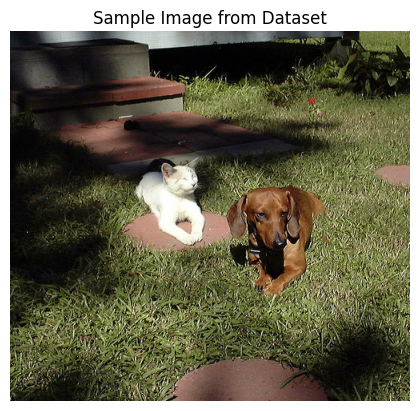


══════════════════════════════════════════════════════════════════════
Episode: 20/2000 [                    ] 1.0%
Time Elapsed: 00:01:37 | ETR: 02:40:22
Epsilon:     1.000   
──────────────────────────────────────────────────────────────────────
📊 Metrics (Avg over last 20):
   ┣━ Reward:      -128.50 
   ┣━ Loss:        0.0000  
   ┗━ Ep. Length:  89.5     steps

⏮️ Last Episode:
   ┣━ Reward:      -82.78  
   ┗━ Length:      99       steps
══════════════════════════════════════════════════════════════════════

══════════════════════════════════════════════════════════════════════
Episode: 40/2000 [                    ] 2.0%
Time Elapsed: 00:03:22 | ETR: 02:45:20
Epsilon:     0.966   
──────────────────────────────────────────────────────────────────────
📊 Metrics (Avg over last 20):
   ┣━ Reward:      -138.20 
   ┣━ Loss:        48.2462 
   ┗━ Ep. Length:  89.5     steps

⏮️ Last Episode:
   ┣━ Reward:      -183.36 
   ┗━ Length:      99       steps
═══════════════════════════════

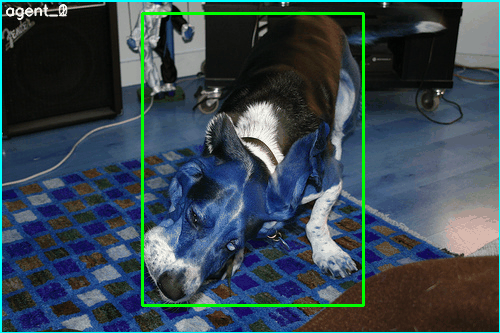

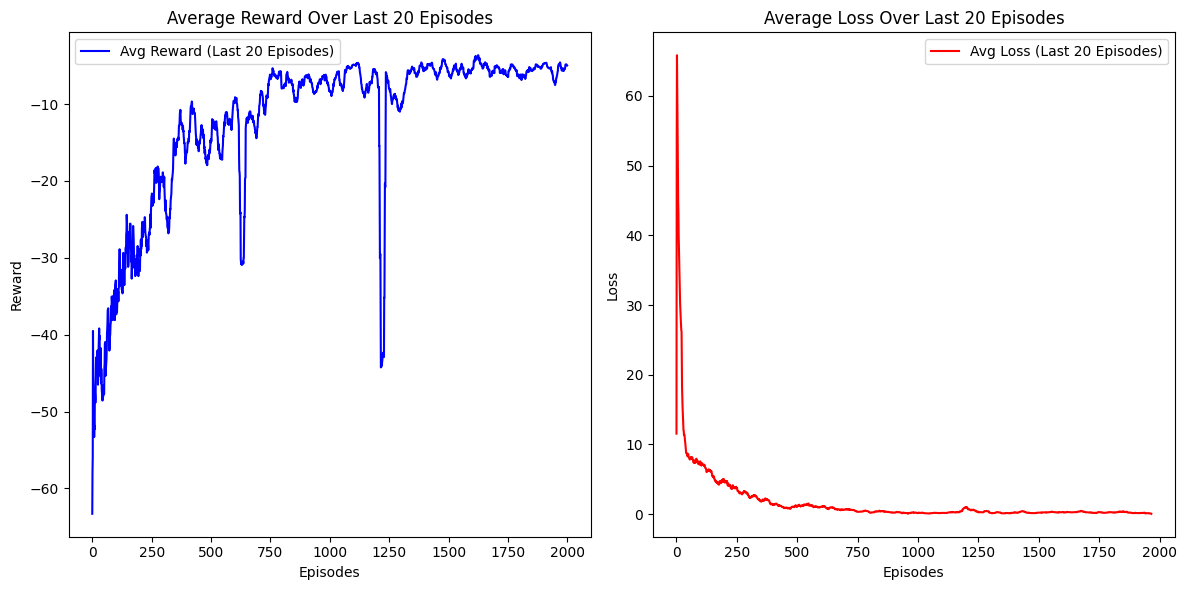

In [9]:
 
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import VOCDetection

TARGET_CLASSES = ['cat', 'dog']
DATA_ROOT = './data'

try:
    original_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='train',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"Filtering for images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

filtered_indices = []
for i in range(len(original_dataset)):
    target = original_dataset[i][1]
    objects = target['annotation']['object']

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects]

    if all(label in TARGET_CLASSES for label in all_labels):
        filtered_indices.append(i)

print(f"Done! Found {len(filtered_indices)} images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_dataset = Subset(original_dataset, filtered_indices)
try:
    val_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='val',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"\nFiltering validation images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

val_filtered_indices = []
for i in range(len(val_dataset)):
    target = val_dataset[i][1]
    objects = target['annotation']['object']

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects]

    if all(label in TARGET_CLASSES for label in all_labels):
        val_filtered_indices.append(i)

print(f"Done! Found {len(val_filtered_indices)} validation images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_val_dataset = Subset(val_dataset, val_filtered_indices)
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

if filtered_dataset:
    idx = np.random.randint(0, len(filtered_dataset))
    image, target = filtered_dataset[idx]
    print(image)
    plt.imshow(image)
    plt.title("Sample Image from Dataset")
    plt.axis('off')  
    plt.show()
import torchvision.transforms as T
from torchvision.models import vgg16
from torchvision.datasets import VOCDetection
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from pettingzoo.utils.env import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import gymnasium as gym
from gymnasium import spaces
from pettingzoo.utils.agent_selector import AgentSelector



def env_creator(env_config):
    return MultiAgentObjectDetectionEnv(**env_config)

class MultiAgentObjectDetectionEnv(AECEnv):
    metadata = {'render_modes': 'rgb_array', 'render_fps': 30, "is_parallelizable": True}

    def __init__(self, dataset, num_agents=3, alpha=0.05, max_steps=100):
        super().__init__()
        self.alpha = alpha
        self.max_steps = max_steps
        self.dataset = dataset
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        vgg_model = vgg16(pretrained=True).eval().to(self.device)
        self.feature_extractor = torch.nn.Sequential(
            *list(vgg_model.features),
            vgg_model.avgpool,
            torch.nn.Flatten(),
            vgg_model.classifier[0]
        ).to(self.device)

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create an empty list to store agent names
        self.possible_agents = []

        # Loop over the range of num_agents (this will run num_agents times)
        for i in range(num_agents):
            # For each number in the loop, create a string "agent_i" (e.g. "agent_0", "agent_1", etc.)
            agent_name = f"agent_{i}"
            
            # Add the created agent name to the list
            self.possible_agents.append(agent_name)
        # Create an empty dictionary to store the mapping of agent names to numbers
        self.agent_name_mapping = {}

        # Loop over each agent name and its index (position) in the list of possible agents
        for i, agent_name in enumerate(self.possible_agents):
            # Add the agent name as the key and its index as the value in the dictionary
            self.agent_name_mapping[agent_name] = i
        
        observation_shape = (4186,)
        # Create an empty dictionary to store observation spaces for each agent
        self._observation_spaces = {}

        # Loop through each agent in the possible_agents list
        for agent in self.possible_agents:
            # Create an observation space for each agent using a box with a specific range
            # A Box space means the agent can have a wide range of possible values (in this case, from negative infinity to positive infinity)
            # 'shape' defines the size of the space (the number of values for each observation)
            # 'dtype' specifies the type of data we are working with (in this case, float32 numbers)
            self._observation_spaces[agent] = spaces.Box(low=-np.inf, high=np.inf, shape=observation_shape, dtype=np.float32)
        # Define the action space for each agent.
        # Each agent can choose from 9 possible actions, so we use Discrete(9) to represent this.
        self._action_spaces = {}

        # Loop through each agent and assign them an action space.
        for agent in self.possible_agents:
            self._action_spaces[agent] = spaces.Discrete(9)
                
        self.agent_colors = [(255, 0, 0), (0, 0, 255), (255, 255, 0)] # BGR for OpenCV


    def observation_space(self, agent):
        return self._observation_spaces[agent]

    def action_space(self, agent):
        return self._action_spaces[agent]

    def _parse_bbox(self, bndbox):
        return np.array([
            int(bndbox["xmin"]), int(bndbox["ymin"]),
            int(bndbox["xmax"]), int(bndbox["ymax"]),
        ])
    def _get_obs_for_agent(self, agent):
        x1, y1, x2, y2 = self.boxes[agent]
        region = self.img[y1:y2, x1:x2]
        
        if region.size == 0:
            region = np.zeros((1, 1, 3), dtype=np.uint8)

        region_img = Image.fromarray(region).convert("RGB")
        region_tensor = self.transform(region_img).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            features = self.feature_extractor(region_tensor).cpu().numpy().flatten()
        
        history_flat = self.histories[agent].flatten()
        obs = np.concatenate([features, history_flat]).astype(np.float32)
        return obs

    def observe(self, agent):
        return self._get_obs_for_agent(agent)
        
    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
      
        # Initialize the dictionaries for rewards, cumulative rewards, terminations, truncations, and info for each agent.

        # This creates a dictionary where each agent starts with a reward of 0.
        self.rewards = {}
        for agent in self.agents:
            self.rewards[agent] = 0

        # This creates a dictionary where each agent starts with a cumulative reward of 0 (tracking the total reward).
        self._cumulative_rewards = {}
        for agent in self.agents:
            self._cumulative_rewards[agent] = 0

        # This creates a dictionary where each agent starts with 'False' for termination (i.e., the agent is not terminated yet).
        self.terminations = {}
        for agent in self.agents:
            self.terminations[agent] = False

        # This creates a dictionary where each agent starts with 'False' for truncation (i.e., the agent is not truncated yet).
        self.truncations = {}
        for agent in self.agents:
            self.truncations[agent] = False

        # This creates a dictionary for additional information about each agent, starting as an empty dictionary.
        self.infos = {}
        for agent in self.agents:
            self.infos[agent] = {}

    
        self.current_step = 0
        self.index = random.randint(0, len(self.dataset) - 1)
        img, annotation = self.dataset[self.index]
        self.img = np.array(img)
        objects = annotation["annotation"]["object"]
        obj = objects[0] if isinstance(objects, list) else objects
        self.gt_box = self._parse_bbox(obj["bndbox"])
        
        height, width = self.img.shape[:2]
        agent_width = width // len(self.agents)
        agent_height = height // len(self.agents)
        self.boxes = {}
        for i, agent in enumerate(self.agents):
            x1 = i * agent_width
            x2 = (i + 1) * agent_width
            if i == len(self.agents) - 1:
                x2 = width
                
            self.boxes[agent] = np.array([0, 0, width, height], dtype=np.int32)
    
        self.histories = {agent: np.zeros((10, 9), dtype=np.float32) for agent in self.agents}
        self.ious = {agent: self._compute_iou(self.boxes[agent], self.gt_box) for agent in self.agents}
    
        self._agent_selector = AgentSelector(self.agents)
        self.agent_selection = self._agent_selector.next()
        
        observations = {agent: self.observe(agent) for agent in self.agents}
        return observations, self.infos


    def step(self, action):
        agent = self.agent_selection
    
        if self.terminations[agent] or self.truncations[agent]:
            self._was_dead_step(action)
            return
    
        self.rewards[agent] = 0
        
        prev_iou = self.ious[agent]
        self._apply_action_for_agent(agent, action)
        new_iou = self._compute_iou(self.boxes[agent], self.gt_box)
        self.ious[agent] = new_iou
        
        if action == 8:  # Trigger action
            if new_iou >= 0.80:
                # If IoU is greater than or equal to 0.80, assign a positive reward and terminate the agent
                self.rewards[agent] = 5.0
                self.terminations[agent] = True  # End the agent's episode
            else:
                # If IoU is less than 0.80, assign a negative reward and continue stepping (do not terminate)
                self.rewards[agent] = -5.0
                self.terminations[agent] = False  # Ensure the agent's episode does not terminate
        else:
            # For all other actions, update the reward based on the IoU change
            self.rewards[agent] = (new_iou - prev_iou) * 10.0 - 0.05  # Small penalty for each step

        for i in self._cumulative_rewards:
            self._cumulative_rewards[i] += self.rewards[agent]
    
        self.histories[agent] = np.roll(self.histories[agent], shift=-1, axis=0)
        self.histories[agent][-1] = np.eye(9)[action]
    
        if self._agent_selector.is_last():
            self.current_step += 1
            if self.current_step >= self.max_steps:
                for ag in self.agents:
                    self.truncations[ag] = True
        
        self.agent_selection = self._agent_selector.next()

    def _was_dead_step(self, action):
        """
        Custom override: when an agent is dead, remove it from the active list
        but KEEP its entries in the per-agent dicts so last() never KeyErrors.
        Also handle the final-agent case gracefully.
        """
        if action is not None:
            raise ValueError("when an agent is dead, the only valid action is None")

        agent = self.agent_selection
        assert self.terminations.get(agent, False) or self.truncations.get(agent, False), (
            f"Agent {agent} is not marked dead but _was_dead_step was called"
        )

        # Remove from active roster
        self.agents.remove(agent)

        # If no agents left, clear selection and exit
        if not self.agents:
            self.agent_selection = None
            # clear any residual rewards but keep dict keys intact
            self._clear_rewards()
            return

        # Advance to the next agent:
        # 1) Prefer any other already‐dead agent (so last() can be called on them)
        dead_list = [ag for ag in self.agents if self.terminations[ag] or self.truncations[ag]]
        if dead_list:
            self.agent_selection = dead_list[0]
        else:
            # 2) Otherwise restore skip pointer if present, or just take the first live one
            self.agent_selection = getattr(self, "_skip_agent_selection", None) or self.agents[0]
            self._skip_agent_selection = None

        # Clear step‐rewards but keep all dict entries
        self._clear_rewards()


    def _apply_action_for_agent(self, agent, action):
        x1, y1, x2, y2 = self.boxes[agent]
        w, h = x2 - x1, y2 - y1
        dx, dy = self.alpha * w, self.alpha * h
        
        action_map = {
            0: (-dx, 0, -dx, 0),    # Move left
            1: (dx, 0, dx, 0),     # Move right
            2: (0, -dy, 0, -dy),   # Move up
            3: (0, dy, 0, dy),     # Move down
            4: (-dx, -dy, dx, dy), # Bigger
            5: (dx, dy, -dx, -dy),  # Smaller
            6: (-dx, 0, dx, 0),    # Fatter
            7: (0, -dy, 0, dy),    # Taller
        }
        
        if action in action_map:
            dx1, dy1, dx2, dy2 = action_map[action]
            x1, y1, x2, y2 = x1 + dx1, y1 + dy1, x2 + dx2, y2 + dy2

        h_img, w_img = self.img.shape[:2]
        x1, x2 = np.clip([x1, x2], 0, w_img)
        y1, y2 = np.clip([y1, y2], 0, h_img)
        
        if x2 <= x1: x2 = x1 + 1
        if y2 <= y1: y2 = y1 + 1

        self.boxes[agent] = np.array([int(x1), int(y1), int(x2), int(y2)])

    def _compute_iou(self, boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        
        iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
        return iou

    def render(self):
        img_to_show = self.img.copy()
        
        gx1, gy1, gx2, gy2 = self.gt_box
        cv2.rectangle(img_to_show, (int(gx1), int(gy1)), (int(gx2), int(gy2)), (0, 255, 0), 2)
        
        for i, agent in enumerate(self.agents):
            x1, y1, x2, y2 = self.boxes[agent]
            color = self.agent_colors[i % len(self.agent_colors)]
            cv2.rectangle(img_to_show, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_color = (255, 255, 255) # White color for good contrast
            thickness = 1
            text_position = (int(x1) + 5, int(y1) + 15)
            cv2.putText(img_to_show, agent, text_position, font, font_scale, font_color, thickness, cv2.LINE_AA)
                
        img_rgb = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
        return img_rgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from typing import Dict, List, Tuple, Optional
import copy
import time
import os


def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Make PyTorch deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for additional determinism
    os.environ['PYTHONHASHSEED'] = str(seed)

class QNetwork(nn.Module):
    """Individual Q-network for each agent"""
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class QMixNet(nn.Module):
    """QMIX mixing network"""
    def __init__(self, n_agents: int, state_dim: int, hidden_dim: int = 32):
        super(QMixNet, self).__init__()
        self.n_agents = n_agents
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        
        # Hypernetworks for weights and biases
        self.hyper_w1 = nn.Linear(state_dim, hidden_dim * n_agents)
        self.hyper_w2 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b1 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, agent_qs, states):
        """
        agent_qs: [batch_size, n_agents]
        states: [batch_size, state_dim]
        """
        batch_size = agent_qs.size(0)
        
        # Generate weights and biases
        w1 = torch.abs(self.hyper_w1(states))  # Ensure positive weights
        w1 = w1.view(batch_size, self.n_agents, self.hidden_dim)
        
        b1 = self.hyper_b1(states)
        b1 = b1.view(batch_size, 1, self.hidden_dim)
        
        # First layer
        agent_qs = agent_qs.view(batch_size, 1, self.n_agents)
        hidden = F.elu(torch.bmm(agent_qs, w1) + b1)
        
        # Second layer
        w2 = torch.abs(self.hyper_w2(states))
        w2 = w2.view(batch_size, self.hidden_dim, 1)
        
        b2 = self.hyper_b2(states)
        b2 = b2.view(batch_size, 1, 1)
        
        q_tot = torch.bmm(hidden, w2) + b2
        q_tot = q_tot.view(batch_size, 1)
        
        return q_tot

class ReplayBuffer:
    """Experience replay buffer for QMIX"""
    def __init__(self, capacity: int, n_agents: int, obs_dim: int, state_dim: int):
        self.capacity = capacity
        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.state_dim = state_dim
        
        self.observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.actions = np.zeros((capacity, n_agents), dtype=np.int64)
        self.rewards = np.zeros((capacity, n_agents), dtype=np.float32)
        self.next_observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.dones = np.zeros((capacity, n_agents), dtype=np.bool_)
        
        self.ptr = 0
        self.size = 0
        
    def store(self, obs, actions, rewards, next_obs, states, next_states, dones):
        self.observations[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.next_observations[self.ptr] = next_obs
        self.states[self.ptr] = states
        self.next_states[self.ptr] = next_states
        self.dones[self.ptr] = dones
        
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
        
    def sample(self, batch_size: int, device: torch.device):
        """Sample batch and move to specified device"""
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        return {
            'observations': torch.FloatTensor(self.observations[idxs]).to(device),
            'actions': torch.LongTensor(self.actions[idxs]).to(device),
            'rewards': torch.FloatTensor(self.rewards[idxs]).to(device),
            'next_observations': torch.FloatTensor(self.next_observations[idxs]).to(device),
            'states': torch.FloatTensor(self.states[idxs]).to(device),
            'next_states': torch.FloatTensor(self.next_states[idxs]).to(device),
            'dones': torch.BoolTensor(self.dones[idxs]).to(device)
        }

class QMIX:
    """QMIX algorithm implementation"""
    def __init__(
        self,
        n_agents: int,
        obs_dim: int,
        action_dim: int,
        state_dim: int,
        lr: float = 1e-3,
        gamma: float = 0.99,
        epsilon: float = 1.0,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.01,
        tau: float = 0.005,
        hidden_dim: int = 128,
        buffer_size: int = 10000,
        batch_size: int = 32,
        device: str = 'cpu',
        seed: Optional[int] = None):
    
        if seed is not None:
            set_random_seed(seed)

        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.batch_size = batch_size
        self.device = torch.device(device)
        
        # Networks
        self.q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        
        self.target_q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        
        self.qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        self.target_qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        
        # Copy weights to target networks
        self.hard_update(self.target_q_networks, self.q_networks)
        self.hard_update(self.target_qmix_net, self.qmix_net)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            lr=lr
        )
        
        # Replay buffer
        self.buffer = ReplayBuffer(buffer_size, n_agents, obs_dim, state_dim)
        
    def hard_update(self, target, source):
        """Hard update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
    
    def soft_update(self, target, source, tau):
        """Soft update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
    def get_actions(self, observations: Dict[str, np.ndarray], epsilon: Optional[float] = None) -> Dict[str, int]:
        """Get actions for all agents using epsilon-greedy policy"""
        if epsilon is None:
            epsilon = self.epsilon
            
        actions = {}
        agent_names = list(observations.keys())
        
        if not agent_names:
            return actions
        
        # Convert observations to tensor and move to device
        obs_array = np.array([observations[agent] for agent in agent_names])
        obs_tensor = torch.FloatTensor(obs_array).to(self.device)
        
        with torch.no_grad():
            q_values = []
            for i, agent in enumerate(agent_names):
                q_vals = self.q_networks[i](obs_tensor[i].unsqueeze(0))
                q_values.append(q_vals)
        
        for i, agent in enumerate(agent_names):
            if random.random() < epsilon:
                actions[agent] = random.randint(0, self.action_dim - 1)
            else:
                actions[agent] = q_values[i].argmax().item()
                
        return actions
    
    def get_state(self, env) -> np.ndarray:
        """Extract global state from environment"""
        # Combine all agent observations and environment info
        state_components = []
        
        # Add current step normalized
        state_components.append(env.current_step / env.max_steps)
        
        # Add all agent box positions normalized
        for agent in env.agents:
            box = env.boxes[agent]
            h, w = env.img.shape[:2]
            normalized_box = [box[0]/w, box[1]/h, box[2]/w, box[3]/h]
            state_components.extend(normalized_box)
        
        # Add ground truth box normalized
        gt_box = env.gt_box
        normalized_gt = [gt_box[0]/w, gt_box[1]/h, gt_box[2]/w, gt_box[3]/h]
        state_components.extend(normalized_gt)
        
        # Add IoU values
        for agent in env.agents:
            state_components.append(env.ious[agent])
        
        # Pad or truncate to fixed size
        target_size = self.state_dim
        if len(state_components) < target_size:
            state_components.extend([0.0] * (target_size - len(state_components)))
        else:
            state_components = state_components[:target_size]
            
        return np.array(state_components, dtype=np.float32)
    
    def store_transition(self, obs, actions, rewards, next_obs, states, next_states, dones):
        """Store transition in replay buffer"""
        agent_names = list(obs.keys())
        
        # Convert to arrays, handling missing agents
        obs_array = np.array([obs[agent] for agent in agent_names])
        actions_array = np.array([actions[agent] for agent in agent_names])
        rewards_array = np.array([rewards.get(agent, 0.0) for agent in agent_names])
        
        # For next_obs, use previous obs if agent is missing (terminated)
        next_obs_array = np.array([
            next_obs[agent] if agent in next_obs else obs[agent] 
            for agent in agent_names
        ])
        
        dones_array = np.array([dones.get(agent, False) for agent in agent_names])
        
        self.buffer.store(obs_array, actions_array, rewards_array, next_obs_array, 
                         states, next_states, dones_array)
    
    def update(self):
        """Update networks using QMIX algorithm"""
        if self.buffer.size < self.batch_size:
            return None
            
        # Sample batch and ensure all tensors are on the correct device
        batch = self.buffer.sample(self.batch_size, self.device)
        
        # Current Q-values
        current_q_values = []
        for i in range(self.n_agents):
            q_vals = self.q_networks[i](batch['observations'][:, i])
            current_q_values.append(q_vals.gather(1, batch['actions'][:, i].unsqueeze(1)).squeeze(1))
        
        current_q_values = torch.stack(current_q_values, dim=1)  # [batch_size, n_agents]
        
        # Target Q-values
        with torch.no_grad():
            target_q_values = []
            for i in range(self.n_agents):
                target_q_vals = self.target_q_networks[i](batch['next_observations'][:, i])
                target_q_values.append(target_q_vals.max(1)[0])
            
            target_q_values = torch.stack(target_q_values, dim=1)  # [batch_size, n_agents]
            
            # Apply done mask
            target_q_values = target_q_values * (~batch['dones']).float()
        
        # Mix Q-values
        current_q_tot = self.qmix_net(current_q_values, batch['states'])
        target_q_tot = self.target_qmix_net(target_q_values, batch['next_states'])
        
        # Compute target
        targets = batch['rewards'].sum(dim=1, keepdim=True) + self.gamma * target_q_tot
        
        # Compute loss
        loss = F.mse_loss(current_q_tot, targets)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            max_norm=1.0
        )
        self.optimizer.step()
        
        # Update target networks
        self.soft_update(self.target_q_networks, self.q_networks, self.tau)
        self.soft_update(self.target_qmix_net, self.qmix_net, self.tau)
        
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        
        return loss.item()

def train_qmix(env, episodes: int = 2000, max_steps: int = 100,  seed: int = 42):
    """Training loop for QMIX on the multi-agent object detection environment"""

    # Set random seed at the beginning of training
    set_random_seed(seed)
    
    # Initialize QMIX
    n_agents = len(env.possible_agents)
    obs_dim = 4186  # From your environment
    action_dim = 9  # From your environment
    state_dim = 50  # Adjust based on your state representation
    
    qmix = QMIX(
        n_agents=n_agents,
        obs_dim=obs_dim,
        action_dim=action_dim,
        state_dim=state_dim,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        seed=seed
    )
    
    episode_rewards = []
    episode_lengths = []
    losses = []
    
    start_time = time.time()
    for episode in range(episodes):
        # Reset environment
        observations, _ = env.reset()
        state = qmix.get_state(env)
        
        episode_reward = 0
        step = 0
        
        while env.agents and step < max_steps:
            # Get actions only for active agents
            active_observations = {agent: observations[agent] for agent in env.agents if agent in observations}
            actions = qmix.get_actions(active_observations)
            
            # Store current state
            prev_observations = observations.copy()
            prev_state = state.copy()
            
            # Execute action for current agent
            current_agent = env.agent_selection
            if current_agent:
                # Check if current agent is dead
                is_dead = (env.terminations.get(current_agent, False) or 
                          env.truncations.get(current_agent, False))
                
                if is_dead:
                    env.step(None)  # Dead agents must receive None
                elif current_agent in actions:
                    env.step(actions[current_agent])
                else:
                    env.step(None)  # Fallback to None if no action available
            else:
                break  # No current agent selected
            
            # Get new observations and rewards
            next_observations = {}
            for agent in env.possible_agents:  # Check all possible agents
                if agent in env.agents:  # Only get obs for active agents
                    try:
                        next_observations[agent] = env.observe(agent)
                    except:
                        # If observation fails, use previous observation
                        if agent in prev_observations:
                            next_observations[agent] = prev_observations[agent]
                        else:
                            continue
                elif agent in prev_observations:
                    # For terminated agents, use their last observation
                    next_observations[agent] = prev_observations[agent]
                    
            episode_lengths.append(step)
            rewards = env.rewards.copy()
            dones = {agent: env.terminations.get(agent, False) or env.truncations.get(agent, False) 
                    for agent in env.possible_agents}
            
            try:
                next_state = qmix.get_state(env)
            except:
                next_state = prev_state  # Fallback if state extraction fails
            
            # Store transition only if we have complete information
            if (len(prev_observations) == n_agents and 
                len(actions) > 0 and 
                len(rewards) > 0):
                
                # Ensure we have actions and rewards for all agents
                full_actions = {}
                full_rewards = {}
                
                for agent in env.possible_agents:
                    full_actions[agent] = actions.get(agent, 0)  # Default action
                    full_rewards[agent] = rewards.get(agent, 0.0)  # Default reward
                
                qmix.store_transition(
                    prev_observations, full_actions, full_rewards, next_observations,
                    prev_state, next_state, dones
                )
            
            # Update observations and state
            observations = next_observations
            state = next_state
            
            # Calculate episode reward
            episode_reward += sum(rewards.values())
            step += 1
            
            # Check if episode is done
            if all(dones[agent] for agent in env.possible_agents) or not env.agents:
                break
        
        episode_rewards.append(episode_reward)
        
        # Update networks
        if episode > 32:  # Start training after some episodes
            loss = qmix.update()
            if loss is not None:
                losses.append(loss)
        
        # Print progress
        if (episode + 1) % 20 == 0:
            # --- Calculate Time Metrics ---
            elapsed_time = time.time() - start_time
            episodes_so_far = episode + 1
            avg_time_per_ep = elapsed_time / episodes_so_far
            remaining_eps = episodes - episodes_so_far
            etr = remaining_eps * avg_time_per_ep
            
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            etr_str = time.strftime("%H:%M:%S", time.gmtime(etr))
            
            # --- Calculate Metric Averages ---
            avg_reward = np.mean(episode_rewards[-20:])
            avg_loss = np.mean(losses[-20:]) if losses else 0.0
            avg_ep_length = np.mean(episode_lengths[-20:])
            
            # --- Get Last Episode's Stats ---
            last_reward = episode_rewards[-1]
            last_ep_length = episode_lengths[-1]

            print("\n" + "═" * 70)
            progress_bar = f"[{'█' * int(20 * episodes_so_far / episodes):<20}]"
            print(f"Episode: {episodes_so_far}/{episodes} {progress_bar} {episodes_so_far / episodes:.1%}")
            print(f"Time Elapsed: {elapsed_str} | ETR: {etr_str}")
            print(f"Epsilon:     {qmix.epsilon:<8.3f}")
            print("─" * 70)
            
            print(f"📊 Metrics (Avg over last 20):")
            print(f"   ┣━ Reward:      {avg_reward:<8.2f}")
            print(f"   ┣━ Loss:        {avg_loss:<8.4f}")
            print(f"   ┗━ Ep. Length:  {avg_ep_length:<8.1f} steps")
            print()
            
            print(f"⏮️ Last Episode:")
            print(f"   ┣━ Reward:      {last_reward:<8.2f}")
            print(f"   ┗━ Length:      {last_ep_length:<8} steps")  
            print("═" * 70)
    
    return qmix, episode_rewards, losses
env = MultiAgentObjectDetectionEnv(filtered_dataset, num_agents=3)

trained_qmix, rewards, losses = train_qmix(env, episodes=2000)
import imageio
from PIL import Image
from IPython.display import display
from IPython.display import Image as IImage
import time

print("\nTesting trained model and capturing frames...")
images = []
obs, _ = env.reset()

# Render the initial state
images.append(env.render())

agent_name_list = list(env.agents)
num_agents = len(agent_name_list)
initial_ious = list(env.ious)
iou_history = [[iou] for iou in initial_ious]
agent_finish_times = [None] * num_agents
start_time = time.time()

for step in range(30):
    if not env.agents:
        print("All agents are done. Resetting.")
        obs, _ = env.reset()
        images.append(env.render())
        
        agent_name_list = list(env.agents)
        num_agents = len(agent_name_list)
        initial_ious = list(env.ious)
        iou_history = [[iou] for iou in initial_ious]
        agent_finish_times = [None] * num_agents
        start_time = time.time()
        continue
        
    # Get actions for active agents only (using original logic)
    active_obs = {agent: obs[agent] for agent in env.agents if agent in obs}
    actions = trained_qmix.get_actions(active_obs, epsilon=0.0)  # No exploration
    
    # Step with current agent (using original logic)
    current_agent = env.agent_selection
    if current_agent:
        # Check if current agent is dead
        is_dead = (env.terminations.get(current_agent, False) or 
                   env.truncations.get(current_agent, False))
        
        if is_dead:
            env.step(None)  # Dead agents must receive None
        elif current_agent in actions:
            env.step(actions[current_agent])
        else:
            env.step(None)  # Fallback
    else:
        break
        
    # Update observations (using original logic)
    obs = {}
    for agent in env.agents:
        try:
            obs[agent] = env.observe(agent)
        except:
            continue
    
    # Track agent finish times
    current_time = time.time()
    for i, agent_name in enumerate(agent_name_list):
        if agent_finish_times[i] is None:
            is_terminated = env.terminations.get(agent_name, False)
            is_truncated = env.truncations.get(agent_name, False)
            if is_terminated or is_truncated:
                agent_finish_times[i] = current_time
    
    # Render the environment after each step to show the progression
    frame = env.render()
    images.append(frame)
    
    # Track IoU history
    current_ious = env.ious
    for i in range(num_agents):
        iou_history[i].append(current_ious[f'agent_{i}'])

end_time = time.time()
for i in range(num_agents):
    if agent_finish_times[i] is None:
        agent_finish_times[i] = end_time

print("Finished simulation.")
env.close()  # It's good practice to close the environment after rendering

# Create animation
animation_path = "trained_agent_animation.gif"
imageio.mimsave(animation_path, images, duration=100, loop=0)
print("Animation saved successfully!")

# Performance summary
print("\n\n" + "═"*55)
print(" " * 15 + "📊 Agent Performance Summary 📊")
print("═"*55)

SUCCESS_THRESHOLD = 0.8

for i in range(num_agents):
    agent_iou_hist = [iou for iou in iou_history[i] if isinstance(iou, (float, int))]
    
    if not agent_iou_hist:
        print(f"\n╭─── Agent {i} ───╮")
        print(f"│ No data recorded. │")
        print(f"╰─────────────╯")
        continue
    
    initial_iou = agent_iou_hist[0]
    final_iou = agent_iou_hist[-1]
    max_iou_achieved = max(agent_iou_hist)
    agent_duration = agent_finish_times[i] - start_time
    
    steps_to_peak = 'N/A'
    if max_iou_achieved > initial_iou:
        try:
            steps_to_peak = agent_iou_hist.index(max_iou_achieved)
        except ValueError:
            steps_to_peak = 'Error'
    
    status = "✅ Success" if final_iou >= SUCCESS_THRESHOLD else "❌ Failure"
    
    print(f"\n╭─── Agent {i} ─────────────")
    print(f"│")
    print(f"│ 🔼 Status:             {status}")
    print(f"│ 🎯 Final IoU:          {final_iou:.4f}")
    print(f"│ 🏆 Peak IoU:           {max_iou_achieved:.4f}")
    print(f"│ ⏱️ Steps to Peak:      {steps_to_peak}")
    print(f"│ 📈 IoU Improvement:    {final_iou - initial_iou:+.4f}")
    print(f"│ ⌛ Agent Time:         {agent_duration:.2f}s")
    print(f"│")
    print(f"╰─────────────────────────")

display(IImage(filename=animation_path))

# Plotting function for rewards and losses over the last 20 episodes
def plot_rewards_and_losses(episode_rewards, losses, window=20,num_agent=3):
    reward_avg = [np.mean(episode_rewards[max(0, i - window):i+1])/3 for i in range(len(episode_rewards))]
    loss_avg = [np.mean(losses[max(0, i - window):i+1]) for i in range(len(losses))]
    
    plt.figure(figsize=(12, 6))
    
    # Plot average rewards
    plt.subplot(1, 2, 1)
    plt.plot(reward_avg, label="Avg Reward (Last 20 Episodes)", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Average Reward Over Last 20 Episodes")
    plt.legend()

    # Plot average losses
    plt.subplot(1, 2, 2)
    plt.plot(loss_avg, label="Avg Loss (Last 20 Episodes)", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Average Loss Over Last 20 Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function to plot the results after training
plot_rewards_and_losses(rewards, losses)

# multi agent third reward

Filtering for images containing ONLY 'cat or dog'...
Done! Found 812 images with ONLY 'cat or dog'.

Filtering validation images containing ONLY 'cat or dog'...
Done! Found 809 validation images with ONLY 'cat or dog'.
<PIL.Image.Image image mode=RGB size=500x375 at 0x2B9564B19D0>


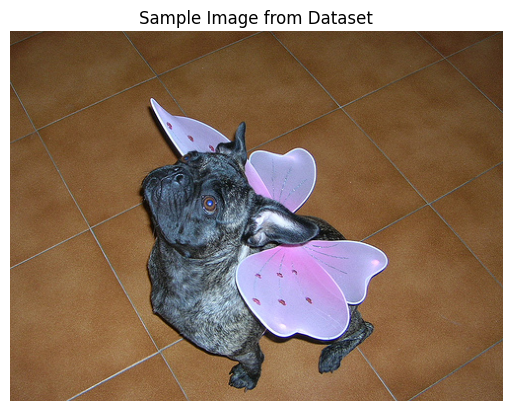


══════════════════════════════════════════════════════════════════════
Episode: 20/2000 [                    ] 1.0%
Time Elapsed: 00:01:37 | ETR: 02:41:11
Epsilon:     1.000   
──────────────────────────────────────────────────────────────────────
📊 Metrics (Avg over last 20):
   ┣━ Reward:      -110.30 
   ┣━ Loss:        0.0000  
   ┗━ Ep. Length:  89.5     steps

⏮️ Last Episode:
   ┣━ Reward:      -66.39  
   ┗━ Length:      99       steps
══════════════════════════════════════════════════════════════════════

══════════════════════════════════════════════════════════════════════
Episode: 40/2000 [                    ] 2.0%
Time Elapsed: 00:03:22 | ETR: 02:45:29
Epsilon:     0.966   
──────────────────────────────────────────────────────────────────────
📊 Metrics (Avg over last 20):
   ┣━ Reward:      -118.89 
   ┣━ Loss:        62.6697 
   ┗━ Ep. Length:  89.5     steps

⏮️ Last Episode:
   ┣━ Reward:      -137.65 
   ┗━ Length:      99       steps
═══════════════════════════════

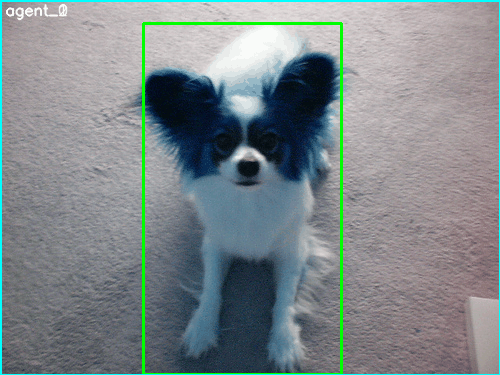

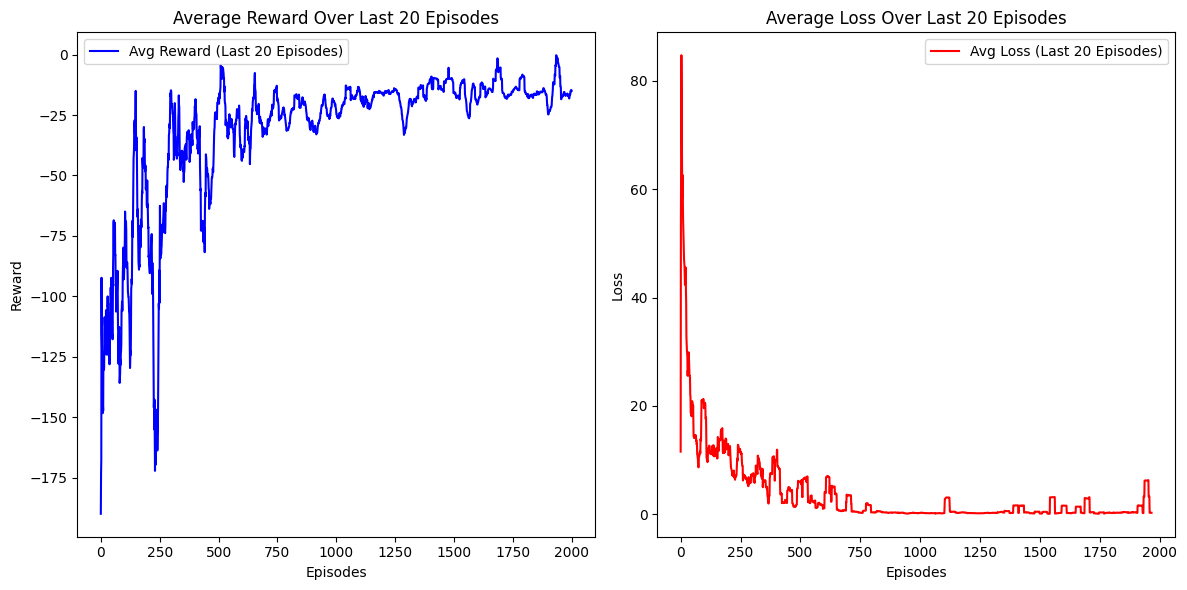

In [11]:
 
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import VOCDetection

TARGET_CLASSES = ['cat', 'dog']
DATA_ROOT = './data'

try:
    original_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='train',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"Filtering for images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

filtered_indices = []
for i in range(len(original_dataset)):
    target = original_dataset[i][1]
    objects = target['annotation']['object']

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects]

    if all(label in TARGET_CLASSES for label in all_labels):
        filtered_indices.append(i)

print(f"Done! Found {len(filtered_indices)} images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_dataset = Subset(original_dataset, filtered_indices)
try:
    val_dataset = VOCDetection(
        root=DATA_ROOT,
        year='2012',
        image_set='val',
        download=True
    )
except Exception as e:
    print(f"Failed to load or download dataset. Make sure you are connected to the internet.")
    print(f"Error: {e}")
    exit()

print(f"\nFiltering validation images containing ONLY '{' or '.join(TARGET_CLASSES)}'...")

val_filtered_indices = []
for i in range(len(val_dataset)):
    target = val_dataset[i][1]
    objects = target['annotation']['object']

    if not isinstance(objects, list):
        objects = [objects]

    all_labels = [obj['name'] for obj in objects]

    if all(label in TARGET_CLASSES for label in all_labels):
        val_filtered_indices.append(i)

print(f"Done! Found {len(val_filtered_indices)} validation images with ONLY '{' or '.join(TARGET_CLASSES)}'.")

filtered_val_dataset = Subset(val_dataset, val_filtered_indices)
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

if filtered_dataset:
    idx = np.random.randint(0, len(filtered_dataset))
    image, target = filtered_dataset[idx]
    print(image)
    plt.imshow(image)
    plt.title("Sample Image from Dataset")
    plt.axis('off')  
    plt.show()
import torchvision.transforms as T
from torchvision.models import vgg16
from torchvision.datasets import VOCDetection
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from pettingzoo.utils.env import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import gymnasium as gym
from gymnasium import spaces
from pettingzoo.utils.agent_selector import AgentSelector



def env_creator(env_config):
    return MultiAgentObjectDetectionEnv(**env_config)

class MultiAgentObjectDetectionEnv(AECEnv):
    metadata = {'render_modes': 'rgb_array', 'render_fps': 30, "is_parallelizable": True}

    def __init__(self, dataset, num_agents=3, alpha=0.05, max_steps=100):
        super().__init__()
        self.alpha = alpha
        self.max_steps = max_steps
        self.dataset = dataset
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        vgg_model = vgg16(pretrained=True).eval().to(self.device)
        self.feature_extractor = torch.nn.Sequential(
            *list(vgg_model.features),
            vgg_model.avgpool,
            torch.nn.Flatten(),
            vgg_model.classifier[0]
        ).to(self.device)

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create an empty list to store agent names
        self.possible_agents = []

        # Loop over the range of num_agents (this will run num_agents times)
        for i in range(num_agents):
            # For each number in the loop, create a string "agent_i" (e.g. "agent_0", "agent_1", etc.)
            agent_name = f"agent_{i}"
            
            # Add the created agent name to the list
            self.possible_agents.append(agent_name)
        # Create an empty dictionary to store the mapping of agent names to numbers
        self.agent_name_mapping = {}

        # Loop over each agent name and its index (position) in the list of possible agents
        for i, agent_name in enumerate(self.possible_agents):
            # Add the agent name as the key and its index as the value in the dictionary
            self.agent_name_mapping[agent_name] = i
        
        observation_shape = (4186,)
        # Create an empty dictionary to store observation spaces for each agent
        self._observation_spaces = {}

        # Loop through each agent in the possible_agents list
        for agent in self.possible_agents:
            # Create an observation space for each agent using a box with a specific range
            # A Box space means the agent can have a wide range of possible values (in this case, from negative infinity to positive infinity)
            # 'shape' defines the size of the space (the number of values for each observation)
            # 'dtype' specifies the type of data we are working with (in this case, float32 numbers)
            self._observation_spaces[agent] = spaces.Box(low=-np.inf, high=np.inf, shape=observation_shape, dtype=np.float32)
        # Define the action space for each agent.
        # Each agent can choose from 9 possible actions, so we use Discrete(9) to represent this.
        self._action_spaces = {}

        # Loop through each agent and assign them an action space.
        for agent in self.possible_agents:
            self._action_spaces[agent] = spaces.Discrete(9)
                
        self.agent_colors = [(255, 0, 0), (0, 0, 255), (255, 255, 0)] # BGR for OpenCV


    def observation_space(self, agent):
        return self._observation_spaces[agent]

    def action_space(self, agent):
        return self._action_spaces[agent]

    def _parse_bbox(self, bndbox):
        return np.array([
            int(bndbox["xmin"]), int(bndbox["ymin"]),
            int(bndbox["xmax"]), int(bndbox["ymax"]),
        ])
    def _get_obs_for_agent(self, agent):
        x1, y1, x2, y2 = self.boxes[agent]
        region = self.img[y1:y2, x1:x2]
        
        if region.size == 0:
            region = np.zeros((1, 1, 3), dtype=np.uint8)

        region_img = Image.fromarray(region).convert("RGB")
        region_tensor = self.transform(region_img).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            features = self.feature_extractor(region_tensor).cpu().numpy().flatten()
        
        history_flat = self.histories[agent].flatten()
        obs = np.concatenate([features, history_flat]).astype(np.float32)
        return obs

    def observe(self, agent):
        return self._get_obs_for_agent(agent)
        
    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
      
        # Initialize the dictionaries for rewards, cumulative rewards, terminations, truncations, and info for each agent.

        # This creates a dictionary where each agent starts with a reward of 0.
        self.rewards = {}
        for agent in self.agents:
            self.rewards[agent] = 0

        # This creates a dictionary where each agent starts with a cumulative reward of 0 (tracking the total reward).
        self._cumulative_rewards = {}
        for agent in self.agents:
            self._cumulative_rewards[agent] = 0

        # This creates a dictionary where each agent starts with 'False' for termination (i.e., the agent is not terminated yet).
        self.terminations = {}
        for agent in self.agents:
            self.terminations[agent] = False

        # This creates a dictionary where each agent starts with 'False' for truncation (i.e., the agent is not truncated yet).
        self.truncations = {}
        for agent in self.agents:
            self.truncations[agent] = False

        # This creates a dictionary for additional information about each agent, starting as an empty dictionary.
        self.infos = {}
        for agent in self.agents:
            self.infos[agent] = {}

    
        self.current_step = 0
        self.index = random.randint(0, len(self.dataset) - 1)
        img, annotation = self.dataset[self.index]
        self.img = np.array(img)
        objects = annotation["annotation"]["object"]
        obj = objects[0] if isinstance(objects, list) else objects
        self.gt_box = self._parse_bbox(obj["bndbox"])
        
        height, width = self.img.shape[:2]
        agent_width = width // len(self.agents)
        agent_height = height // len(self.agents)
        self.boxes = {}
        for i, agent in enumerate(self.agents):
            x1 = i * agent_width
            x2 = (i + 1) * agent_width
            if i == len(self.agents) - 1:
                x2 = width
                
            self.boxes[agent] = np.array([0, 0, width, height], dtype=np.int32)
    
        self.histories = {agent: np.zeros((10, 9), dtype=np.float32) for agent in self.agents}
        self.ious = {agent: self._compute_iou(self.boxes[agent], self.gt_box) for agent in self.agents}
    
        self._agent_selector = AgentSelector(self.agents)
        self.agent_selection = self._agent_selector.next()
        
        observations = {agent: self.observe(agent) for agent in self.agents}
        return observations, self.infos


    def step(self, action):
        agent = self.agent_selection
    
        if self.terminations[agent] or self.truncations[agent]:
            self._was_dead_step(action)
            return
    
        self.rewards[agent] = 0
        
        prev_iou = self.ious[agent]
        self._apply_action_for_agent(agent, action)
        new_iou = self._compute_iou(self.boxes[agent], self.gt_box)
        self.ious[agent] = new_iou
        
        if action == 8:  # Trigger action
            if new_iou >= 0.80:
                num_success = sum(iou >= 0.8 for iou in self.ious.values())
                team_reward = 5.0 * num_success
                
                for ag in self.agents:
                    self.rewards[ag] = team_reward
                    self._cumulative_rewards[ag] += team_reward

                self.terminations[agent] = True
            else:
                self.rewards[agent] = -5.0
                self._cumulative_rewards[agent] += self.rewards[agent]
                self.terminations[agent] = False
        else:
            # Normal step reward for moving
            self.rewards[agent] = (new_iou - prev_iou) * 10.0 - 0.05
            self._cumulative_rewards[agent] += self.rewards[agent]

    
        self.histories[agent] = np.roll(self.histories[agent], shift=-1, axis=0)
        self.histories[agent][-1] = np.eye(9)[action]
    
        if self._agent_selector.is_last():
            self.current_step += 1
            if self.current_step >= self.max_steps:
                for ag in self.agents:
                    self.truncations[ag] = True
        
        self.agent_selection = self._agent_selector.next()

    def _was_dead_step(self, action):
        """
        Custom override: when an agent is dead, remove it from the active list
        but KEEP its entries in the per-agent dicts so last() never KeyErrors.
        Also handle the final-agent case gracefully.
        """
        if action is not None:
            raise ValueError("when an agent is dead, the only valid action is None")

        agent = self.agent_selection
        assert self.terminations.get(agent, False) or self.truncations.get(agent, False), (
            f"Agent {agent} is not marked dead but _was_dead_step was called"
        )

        # Remove from active roster
        self.agents.remove(agent)

        # If no agents left, clear selection and exit
        if not self.agents:
            self.agent_selection = None
            # clear any residual rewards but keep dict keys intact
            self._clear_rewards()
            return

        # Advance to the next agent:
        # 1) Prefer any other already‐dead agent (so last() can be called on them)
        dead_list = [ag for ag in self.agents if self.terminations[ag] or self.truncations[ag]]
        if dead_list:
            self.agent_selection = dead_list[0]
        else:
            # 2) Otherwise restore skip pointer if present, or just take the first live one
            self.agent_selection = getattr(self, "_skip_agent_selection", None) or self.agents[0]
            self._skip_agent_selection = None

        # Clear step‐rewards but keep all dict entries
        self._clear_rewards()


    def _apply_action_for_agent(self, agent, action):
        x1, y1, x2, y2 = self.boxes[agent]
        w, h = x2 - x1, y2 - y1
        dx, dy = self.alpha * w, self.alpha * h
        
        action_map = {
            0: (-dx, 0, -dx, 0),    # Move left
            1: (dx, 0, dx, 0),     # Move right
            2: (0, -dy, 0, -dy),   # Move up
            3: (0, dy, 0, dy),     # Move down
            4: (-dx, -dy, dx, dy), # Bigger
            5: (dx, dy, -dx, -dy),  # Smaller
            6: (-dx, 0, dx, 0),    # Fatter
            7: (0, -dy, 0, dy),    # Taller
        }
        
        if action in action_map:
            dx1, dy1, dx2, dy2 = action_map[action]
            x1, y1, x2, y2 = x1 + dx1, y1 + dy1, x2 + dx2, y2 + dy2

        h_img, w_img = self.img.shape[:2]
        x1, x2 = np.clip([x1, x2], 0, w_img)
        y1, y2 = np.clip([y1, y2], 0, h_img)
        
        if x2 <= x1: x2 = x1 + 1
        if y2 <= y1: y2 = y1 + 1

        self.boxes[agent] = np.array([int(x1), int(y1), int(x2), int(y2)])

    def _compute_iou(self, boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        
        iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
        return iou

    def render(self):
        img_to_show = self.img.copy()
        
        gx1, gy1, gx2, gy2 = self.gt_box
        cv2.rectangle(img_to_show, (int(gx1), int(gy1)), (int(gx2), int(gy2)), (0, 255, 0), 2)
        
        for i, agent in enumerate(self.agents):
            x1, y1, x2, y2 = self.boxes[agent]
            color = self.agent_colors[i % len(self.agent_colors)]
            cv2.rectangle(img_to_show, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_color = (255, 255, 255) # White color for good contrast
            thickness = 1
            text_position = (int(x1) + 5, int(y1) + 15)
            cv2.putText(img_to_show, agent, text_position, font, font_scale, font_color, thickness, cv2.LINE_AA)
                
        img_rgb = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
        return img_rgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from typing import Dict, List, Tuple, Optional
import copy
import time
import os


def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Make PyTorch deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for additional determinism
    os.environ['PYTHONHASHSEED'] = str(seed)

class QNetwork(nn.Module):
    """Individual Q-network for each agent"""
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class QMixNet(nn.Module):
    """QMIX mixing network"""
    def __init__(self, n_agents: int, state_dim: int, hidden_dim: int = 32):
        super(QMixNet, self).__init__()
        self.n_agents = n_agents
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        
        # Hypernetworks for weights and biases
        self.hyper_w1 = nn.Linear(state_dim, hidden_dim * n_agents)
        self.hyper_w2 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b1 = nn.Linear(state_dim, hidden_dim)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, agent_qs, states):
        """
        agent_qs: [batch_size, n_agents]
        states: [batch_size, state_dim]
        """
        batch_size = agent_qs.size(0)
        
        # Generate weights and biases
        w1 = torch.abs(self.hyper_w1(states))  # Ensure positive weights
        w1 = w1.view(batch_size, self.n_agents, self.hidden_dim)
        
        b1 = self.hyper_b1(states)
        b1 = b1.view(batch_size, 1, self.hidden_dim)
        
        # First layer
        agent_qs = agent_qs.view(batch_size, 1, self.n_agents)
        hidden = F.elu(torch.bmm(agent_qs, w1) + b1)
        
        # Second layer
        w2 = torch.abs(self.hyper_w2(states))
        w2 = w2.view(batch_size, self.hidden_dim, 1)
        
        b2 = self.hyper_b2(states)
        b2 = b2.view(batch_size, 1, 1)
        
        q_tot = torch.bmm(hidden, w2) + b2
        q_tot = q_tot.view(batch_size, 1)
        
        return q_tot

class ReplayBuffer:
    """Experience replay buffer for QMIX"""
    def __init__(self, capacity: int, n_agents: int, obs_dim: int, state_dim: int):
        self.capacity = capacity
        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.state_dim = state_dim
        
        self.observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.actions = np.zeros((capacity, n_agents), dtype=np.int64)
        self.rewards = np.zeros((capacity, n_agents), dtype=np.float32)
        self.next_observations = np.zeros((capacity, n_agents, obs_dim), dtype=np.float32)
        self.states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.dones = np.zeros((capacity, n_agents), dtype=np.bool_)
        
        self.ptr = 0
        self.size = 0
        
    def store(self, obs, actions, rewards, next_obs, states, next_states, dones):
        self.observations[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.next_observations[self.ptr] = next_obs
        self.states[self.ptr] = states
        self.next_states[self.ptr] = next_states
        self.dones[self.ptr] = dones
        
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
        
    def sample(self, batch_size: int, device: torch.device):
        """Sample batch and move to specified device"""
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        return {
            'observations': torch.FloatTensor(self.observations[idxs]).to(device),
            'actions': torch.LongTensor(self.actions[idxs]).to(device),
            'rewards': torch.FloatTensor(self.rewards[idxs]).to(device),
            'next_observations': torch.FloatTensor(self.next_observations[idxs]).to(device),
            'states': torch.FloatTensor(self.states[idxs]).to(device),
            'next_states': torch.FloatTensor(self.next_states[idxs]).to(device),
            'dones': torch.BoolTensor(self.dones[idxs]).to(device)
        }

class QMIX:
    """QMIX algorithm implementation"""
    def __init__(
        self,
        n_agents: int,
        obs_dim: int,
        action_dim: int,
        state_dim: int,
        lr: float = 1e-3,
        gamma: float = 0.99,
        epsilon: float = 1.0,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.01,
        tau: float = 0.005,
        hidden_dim: int = 128,
        buffer_size: int = 10000,
        batch_size: int = 32,
        device: str = 'cpu',
        seed: Optional[int] = None):
    
        if seed is not None:
            set_random_seed(seed)

        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.batch_size = batch_size
        self.device = torch.device(device)
        
        # Networks
        self.q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        
        self.target_q_networks = nn.ModuleList([
            QNetwork(obs_dim, hidden_dim, action_dim) for _ in range(n_agents)
        ]).to(self.device)
        
        self.qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        self.target_qmix_net = QMixNet(n_agents, state_dim).to(self.device)
        
        # Copy weights to target networks
        self.hard_update(self.target_q_networks, self.q_networks)
        self.hard_update(self.target_qmix_net, self.qmix_net)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            lr=lr
        )
        
        # Replay buffer
        self.buffer = ReplayBuffer(buffer_size, n_agents, obs_dim, state_dim)
        
    def hard_update(self, target, source):
        """Hard update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
    
    def soft_update(self, target, source, tau):
        """Soft update target networks"""
        if isinstance(target, nn.ModuleList):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        else:
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
    def get_actions(self, observations: Dict[str, np.ndarray], epsilon: Optional[float] = None) -> Dict[str, int]:
        """Get actions for all agents using epsilon-greedy policy"""
        if epsilon is None:
            epsilon = self.epsilon
            
        actions = {}
        agent_names = list(observations.keys())
        
        if not agent_names:
            return actions
        
        # Convert observations to tensor and move to device
        obs_array = np.array([observations[agent] for agent in agent_names])
        obs_tensor = torch.FloatTensor(obs_array).to(self.device)
        
        with torch.no_grad():
            q_values = []
            for i, agent in enumerate(agent_names):
                q_vals = self.q_networks[i](obs_tensor[i].unsqueeze(0))
                q_values.append(q_vals)
        
        for i, agent in enumerate(agent_names):
            if random.random() < epsilon:
                actions[agent] = random.randint(0, self.action_dim - 1)
            else:
                actions[agent] = q_values[i].argmax().item()
                
        return actions
    
    def get_state(self, env) -> np.ndarray:
        """Extract global state from environment"""
        # Combine all agent observations and environment info
        state_components = []
        
        # Add current step normalized
        state_components.append(env.current_step / env.max_steps)
        
        # Add all agent box positions normalized
        for agent in env.agents:
            box = env.boxes[agent]
            h, w = env.img.shape[:2]
            normalized_box = [box[0]/w, box[1]/h, box[2]/w, box[3]/h]
            state_components.extend(normalized_box)
        
        # Add ground truth box normalized
        gt_box = env.gt_box
        normalized_gt = [gt_box[0]/w, gt_box[1]/h, gt_box[2]/w, gt_box[3]/h]
        state_components.extend(normalized_gt)
        
        # Add IoU values
        for agent in env.agents:
            state_components.append(env.ious[agent])
        
        # Pad or truncate to fixed size
        target_size = self.state_dim
        if len(state_components) < target_size:
            state_components.extend([0.0] * (target_size - len(state_components)))
        else:
            state_components = state_components[:target_size]
            
        return np.array(state_components, dtype=np.float32)
    
    def store_transition(self, obs, actions, rewards, next_obs, states, next_states, dones):
        """Store transition in replay buffer"""
        agent_names = list(obs.keys())
        
        # Convert to arrays, handling missing agents
        obs_array = np.array([obs[agent] for agent in agent_names])
        actions_array = np.array([actions[agent] for agent in agent_names])
        rewards_array = np.array([rewards.get(agent, 0.0) for agent in agent_names])
        
        # For next_obs, use previous obs if agent is missing (terminated)
        next_obs_array = np.array([
            next_obs[agent] if agent in next_obs else obs[agent] 
            for agent in agent_names
        ])
        
        dones_array = np.array([dones.get(agent, False) for agent in agent_names])
        
        self.buffer.store(obs_array, actions_array, rewards_array, next_obs_array, 
                         states, next_states, dones_array)
    
    def update(self):
        """Update networks using QMIX algorithm"""
        if self.buffer.size < self.batch_size:
            return None
            
        # Sample batch and ensure all tensors are on the correct device
        batch = self.buffer.sample(self.batch_size, self.device)
        
        # Current Q-values
        current_q_values = []
        for i in range(self.n_agents):
            q_vals = self.q_networks[i](batch['observations'][:, i])
            current_q_values.append(q_vals.gather(1, batch['actions'][:, i].unsqueeze(1)).squeeze(1))
        
        current_q_values = torch.stack(current_q_values, dim=1)  # [batch_size, n_agents]
        
        # Target Q-values
        with torch.no_grad():
            target_q_values = []
            for i in range(self.n_agents):
                target_q_vals = self.target_q_networks[i](batch['next_observations'][:, i])
                target_q_values.append(target_q_vals.max(1)[0])
            
            target_q_values = torch.stack(target_q_values, dim=1)  # [batch_size, n_agents]
            
            # Apply done mask
            target_q_values = target_q_values * (~batch['dones']).float()
        
        # Mix Q-values
        current_q_tot = self.qmix_net(current_q_values, batch['states'])
        target_q_tot = self.target_qmix_net(target_q_values, batch['next_states'])
        
        # Compute target
        targets = batch['rewards'].sum(dim=1, keepdim=True) + self.gamma * target_q_tot
        
        # Compute loss
        loss = F.mse_loss(current_q_tot, targets)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.q_networks.parameters()) + list(self.qmix_net.parameters()),
            max_norm=1.0
        )
        self.optimizer.step()
        
        # Update target networks
        self.soft_update(self.target_q_networks, self.q_networks, self.tau)
        self.soft_update(self.target_qmix_net, self.qmix_net, self.tau)
        
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        
        return loss.item()

def train_qmix(env, episodes: int = 2000, max_steps: int = 100,  seed: int = 42):
    """Training loop for QMIX on the multi-agent object detection environment"""

    # Set random seed at the beginning of training
    set_random_seed(seed)
    
    # Initialize QMIX
    n_agents = len(env.possible_agents)
    obs_dim = 4186  # From your environment
    action_dim = 9  # From your environment
    state_dim = 50  # Adjust based on your state representation
    
    qmix = QMIX(
        n_agents=n_agents,
        obs_dim=obs_dim,
        action_dim=action_dim,
        state_dim=state_dim,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        seed=seed
    )
    
    episode_rewards = []
    episode_lengths = []
    losses = []
    
    start_time = time.time()
    for episode in range(episodes):
        # Reset environment
        observations, _ = env.reset()
        state = qmix.get_state(env)
        
        episode_reward = 0
        step = 0
        
        while env.agents and step < max_steps:
            # Get actions only for active agents
            active_observations = {agent: observations[agent] for agent in env.agents if agent in observations}
            actions = qmix.get_actions(active_observations)
            
            # Store current state
            prev_observations = observations.copy()
            prev_state = state.copy()
            
            # Execute action for current agent
            current_agent = env.agent_selection
            if current_agent:
                # Check if current agent is dead
                is_dead = (env.terminations.get(current_agent, False) or 
                          env.truncations.get(current_agent, False))
                
                if is_dead:
                    env.step(None)  # Dead agents must receive None
                elif current_agent in actions:
                    env.step(actions[current_agent])
                else:
                    env.step(None)  # Fallback to None if no action available
            else:
                break  # No current agent selected
            
            # Get new observations and rewards
            next_observations = {}
            for agent in env.possible_agents:  # Check all possible agents
                if agent in env.agents:  # Only get obs for active agents
                    try:
                        next_observations[agent] = env.observe(agent)
                    except:
                        # If observation fails, use previous observation
                        if agent in prev_observations:
                            next_observations[agent] = prev_observations[agent]
                        else:
                            continue
                elif agent in prev_observations:
                    # For terminated agents, use their last observation
                    next_observations[agent] = prev_observations[agent]
                    
            episode_lengths.append(step)
            rewards = env.rewards.copy()
            dones = {agent: env.terminations.get(agent, False) or env.truncations.get(agent, False) 
                    for agent in env.possible_agents}
            
            try:
                next_state = qmix.get_state(env)
            except:
                next_state = prev_state  # Fallback if state extraction fails
            
            # Store transition only if we have complete information
            if (len(prev_observations) == n_agents and 
                len(actions) > 0 and 
                len(rewards) > 0):
                
                # Ensure we have actions and rewards for all agents
                full_actions = {}
                full_rewards = {}
                
                for agent in env.possible_agents:
                    full_actions[agent] = actions.get(agent, 0)  # Default action
                    full_rewards[agent] = rewards.get(agent, 0.0)  # Default reward
                
                qmix.store_transition(
                    prev_observations, full_actions, full_rewards, next_observations,
                    prev_state, next_state, dones
                )
            
            # Update observations and state
            observations = next_observations
            state = next_state
            
            # Calculate episode reward
            episode_reward += sum(rewards.values())
            step += 1
            
            # Check if episode is done
            if all(dones[agent] for agent in env.possible_agents) or not env.agents:
                break
        
        episode_rewards.append(episode_reward)
        
        # Update networks
        if episode > 32:  # Start training after some episodes
            loss = qmix.update()
            if loss is not None:
                losses.append(loss)
        
        # Print progress
        if (episode + 1) % 20 == 0:
            # --- Calculate Time Metrics ---
            elapsed_time = time.time() - start_time
            episodes_so_far = episode + 1
            avg_time_per_ep = elapsed_time / episodes_so_far
            remaining_eps = episodes - episodes_so_far
            etr = remaining_eps * avg_time_per_ep
            
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            etr_str = time.strftime("%H:%M:%S", time.gmtime(etr))
            
            # --- Calculate Metric Averages ---
            avg_reward = np.mean(episode_rewards[-20:])
            avg_loss = np.mean(losses[-20:]) if losses else 0.0
            avg_ep_length = np.mean(episode_lengths[-20:])
            
            # --- Get Last Episode's Stats ---
            last_reward = episode_rewards[-1]
            last_ep_length = episode_lengths[-1]

            print("\n" + "═" * 70)
            progress_bar = f"[{'█' * int(20 * episodes_so_far / episodes):<20}]"
            print(f"Episode: {episodes_so_far}/{episodes} {progress_bar} {episodes_so_far / episodes:.1%}")
            print(f"Time Elapsed: {elapsed_str} | ETR: {etr_str}")
            print(f"Epsilon:     {qmix.epsilon:<8.3f}")
            print("─" * 70)
            
            print(f"📊 Metrics (Avg over last 20):")
            print(f"   ┣━ Reward:      {avg_reward:<8.2f}")
            print(f"   ┣━ Loss:        {avg_loss:<8.4f}")
            print(f"   ┗━ Ep. Length:  {avg_ep_length:<8.1f} steps")
            print()
            
            print(f"⏮️ Last Episode:")
            print(f"   ┣━ Reward:      {last_reward:<8.2f}")
            print(f"   ┗━ Length:      {last_ep_length:<8} steps")  
            print("═" * 70)
    
    return qmix, episode_rewards, losses
env = MultiAgentObjectDetectionEnv(filtered_dataset, num_agents=3)

trained_qmix, rewards, losses = train_qmix(env, episodes=2000)
import imageio
from PIL import Image
from IPython.display import display
from IPython.display import Image as IImage
import time

print("\nTesting trained model and capturing frames...")
images = []
obs, _ = env.reset()

# Render the initial state
images.append(env.render())

agent_name_list = list(env.agents)
num_agents = len(agent_name_list)
initial_ious = list(env.ious)
iou_history = [[iou] for iou in initial_ious]
agent_finish_times = [None] * num_agents
start_time = time.time()

for step in range(30):
    if not env.agents:
        print("All agents are done. Resetting.")
        obs, _ = env.reset()
        images.append(env.render())
        
        agent_name_list = list(env.agents)
        num_agents = len(agent_name_list)
        initial_ious = list(env.ious)
        iou_history = [[iou] for iou in initial_ious]
        agent_finish_times = [None] * num_agents
        start_time = time.time()
        continue
        
    # Get actions for active agents only (using original logic)
    active_obs = {agent: obs[agent] for agent in env.agents if agent in obs}
    actions = trained_qmix.get_actions(active_obs, epsilon=0.0)  # No exploration
    
    # Step with current agent (using original logic)
    current_agent = env.agent_selection
    if current_agent:
        # Check if current agent is dead
        is_dead = (env.terminations.get(current_agent, False) or 
                   env.truncations.get(current_agent, False))
        
        if is_dead:
            env.step(None)  # Dead agents must receive None
        elif current_agent in actions:
            env.step(actions[current_agent])
        else:
            env.step(None)  # Fallback
    else:
        break
        
    # Update observations (using original logic)
    obs = {}
    for agent in env.agents:
        try:
            obs[agent] = env.observe(agent)
        except:
            continue
    
    # Track agent finish times
    current_time = time.time()
    for i, agent_name in enumerate(agent_name_list):
        if agent_finish_times[i] is None:
            is_terminated = env.terminations.get(agent_name, False)
            is_truncated = env.truncations.get(agent_name, False)
            if is_terminated or is_truncated:
                agent_finish_times[i] = current_time
    
    # Render the environment after each step to show the progression
    frame = env.render()
    images.append(frame)
    
    # Track IoU history
    current_ious = env.ious
    for i in range(num_agents):
        iou_history[i].append(current_ious[f'agent_{i}'])

end_time = time.time()
for i in range(num_agents):
    if agent_finish_times[i] is None:
        agent_finish_times[i] = end_time

print("Finished simulation.")
env.close()  # It's good practice to close the environment after rendering

# Create animation
animation_path = "trained_agent_animation.gif"
imageio.mimsave(animation_path, images, duration=100, loop=0)
print("Animation saved successfully!")

# Performance summary
print("\n\n" + "═"*55)
print(" " * 15 + "📊 Agent Performance Summary 📊")
print("═"*55)

SUCCESS_THRESHOLD = 0.8

for i in range(num_agents):
    agent_iou_hist = [iou for iou in iou_history[i] if isinstance(iou, (float, int))]
    
    if not agent_iou_hist:
        print(f"\n╭─── Agent {i} ───╮")
        print(f"│ No data recorded. │")
        print(f"╰─────────────╯")
        continue
    
    initial_iou = agent_iou_hist[0]
    final_iou = agent_iou_hist[-1]
    max_iou_achieved = max(agent_iou_hist)
    agent_duration = agent_finish_times[i] - start_time
    
    steps_to_peak = 'N/A'
    if max_iou_achieved > initial_iou:
        try:
            steps_to_peak = agent_iou_hist.index(max_iou_achieved)
        except ValueError:
            steps_to_peak = 'Error'
    
    status = "✅ Success" if final_iou >= SUCCESS_THRESHOLD else "❌ Failure"
    
    print(f"\n╭─── Agent {i} ─────────────")
    print(f"│")
    print(f"│ 🔼 Status:             {status}")
    print(f"│ 🎯 Final IoU:          {final_iou:.4f}")
    print(f"│ 🏆 Peak IoU:           {max_iou_achieved:.4f}")
    print(f"│ ⏱️ Steps to Peak:      {steps_to_peak}")
    print(f"│ 📈 IoU Improvement:    {final_iou - initial_iou:+.4f}")
    print(f"│ ⌛ Agent Time:         {agent_duration:.2f}s")
    print(f"│")
    print(f"╰─────────────────────────")

display(IImage(filename=animation_path))

# Plotting function for rewards and losses over the last 20 episodes
def plot_rewards_and_losses(episode_rewards, losses, window=20):
    reward_avg = [np.mean(episode_rewards[max(0, i - window):i+1]) for i in range(len(episode_rewards))]
    loss_avg = [np.mean(losses[max(0, i - window):i+1]) for i in range(len(losses))]
    
    plt.figure(figsize=(12, 6))
    
    # Plot average rewards
    plt.subplot(1, 2, 1)
    plt.plot(reward_avg, label="Avg Reward (Last 20 Episodes)", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Average Reward Over Last 20 Episodes")
    plt.legend()

    # Plot average losses
    plt.subplot(1, 2, 2)
    plt.plot(loss_avg, label="Avg Loss (Last 20 Episodes)", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Average Loss Over Last 20 Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function to plot the results after training
plot_rewards_and_losses(rewards, losses)